#  <center> </center>
# <center>Trabajo Practico 1 </center>
### <center>Grupo 10 </center>
## Integrantes:
#### Alan Richmond
#### Flavian Ferré
#### Camila Lucia Avalos
#### Alan Mejia

# 0. Inicializacion de los datos

### Importando Librerias


In [1]:
#Manipulacion de datos
import pandas as pd
import numpy as np
import seaborn as sns

from pandas.plotting import scatter_matrix
from shapely.wkt import loads
from shapely.geometry import Point, MultiPolygon
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

### Seleccion de datos

Cargamos el archivo de datos en un dataframe de Pandas

In [2]:
df_properati = pd.read_csv('Datasets/properati_argentina_2021.csv')

Realizamos una copia del dataset sobre el cual vamos a trabajar para no alterar los datos originales

In [3]:
df_trabajo = df_properati.copy()

#cantidad de columnas y filas del df inicial

In [4]:
df_trabajo.shape

(460154, 20)

#Filtrado de los datos que se van a utilizar.

In [5]:
#filtrando solo las propiedades que esten publicadas en dolares
filtrado_de_moneda = (df_trabajo["property_currency"] == "USD")

In [6]:
#filtrando solo las propiedades que sean casa,ph y departamento
tipos_propiedad = ["Casa", "PH", "Departamento"]
filtrado_de_vivienda = (df_trabajo["property_type"].isin(tipos_propiedad))

In [7]:
#filtrando solo las propiedades que esten en Venta
filtrado_de_operacion = (df_trabajo["operation"] == "Venta")

In [8]:
#filtrando solo las propiedades que esten ubicadas en capital federal
filtrado_de_ubicacion = (df_trabajo["place_l2"] == "Capital Federal")

In [9]:
# Se juntan todos los filtrados que se tienen que cumplir
filtrados_unidos = filtrado_de_moneda & filtrado_de_vivienda & filtrado_de_operacion & filtrado_de_ubicacion

In [10]:
df_filtrado = df_trabajo[filtrados_unidos]

Cantidad de Filas y Columnas que quedaron luego de la filtracion

In [11]:
df_filtrado.shape

(94249, 20)

### Dividir en conjuntos de entrenamiento y prueba

In [12]:
total_filas = len(df_filtrado)
filas_entrenamiento = int(0.8 * total_filas)

conjunto_entrenamiento = df_filtrado[:filas_entrenamiento]
conjunto_prueba = df_filtrado[filas_entrenamiento:]


#Conjunto de entrenamiento

In [13]:
#Imprime las primeras filas del conjunto de entrenamiento
print("Conjunto de Entrenamiento:")
conjunto_entrenamiento.head()



Conjunto de Entrenamiento:


,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,NaN,NaN,NaN,Venta,Departamento,4.0,2.0,NaN,104.0,146000.0,USD,Venta departamento 4 ambientes Once
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,4.0,2.0,NaN,73.0,250000.0,USD,PH - Boedo


#Conjunto de Prueba

In [14]:
#Imprime las primeras filas del conjunto de pruebas
print("Conjunto de Prueba:")
conjunto_prueba.head()

Conjunto de Prueba:


,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
372676,dSC4wqerxQ5zoezS10hyig==,2021-08-24,2021-08-27,2021-08-24,-34.594832,-58.419821,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,26.0,26.0,64765.0,USD,MONOAMBIENTE EMPRENDIMIENTO PALERMO SOHO
372677,bObxHjQo1w/XUoA1CjdLtg==,2021-08-24,2021-08-24,2021-08-24,-34.585604,-58.423957,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,1.0,NaN,32.0,30.0,110000.0,USD,Venta departamento en palermo monoambiente
372679,xIjDPpdsenrj6u6ErpdNhg==,2021-08-24,2021-08-27,2021-08-24,-34.582800,-58.442800,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,36.0,32.0,93621.0,USD,VENTA 1 AMBIENTE de 32 a 66 m² -VIVIENDA/ ESTU...
372682,8b+kN4SeOF7UBH5dpfvg0Q==,2021-08-24,2021-10-18,2021-08-24,-34.577400,-58.433300,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,42.0,38.0,79900.0,USD,VENTA DEPARTAMENTO 2 AMBIENTES EN PALERMO
372683,O1XW6eVlW04mfAkXRKePkQ==,2021-08-24,2022-03-21,2021-08-24,-34.575328,-58.420624,Capital Federal,Palermo,NaN,NaN,NaN,Venta,Departamento,2.0,NaN,47.0,41.0,155000.0,USD,DEPARTAMENTO DUPLEX 2 AMBIENTES CON 2 BALCONES...


#Cantidad de propiedades que quedaron en el conjunto de entrenamiento y de prueba



In [15]:
conjunto_entrenamiento.shape


(75399, 20)

In [16]:
conjunto_prueba.shape

(18850, 20)

# 1. Analisis Exploratorio y Preprocesamiento de Datos

## a. Exploracion Inicial

### Variables cuantitativas

Las variables que podemos identificar como cuantitativas son las siguientes : latitud, longitud, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price

In [17]:
variables_cuantitativas = ['latitud', 'longitud', 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_price']
medidas_de_resumen = pd.DataFrame(columns=variables_cuantitativas, index=['Promedia', 'Minimo', 'Cuartil 1', 'Mediana', 'Cuartil 3', 'Maximo', 'Moda', 'Varianza', 'Desviacion estandar', 'Rango intercuartilico'])

for i in variables_cuantitativas:
    promedia = conjunto_entrenamiento[i].mean()
    minimo = conjunto_entrenamiento[i].min()
    cuartil_1 = conjunto_entrenamiento[i].quantile(0.25)
    mediana = conjunto_entrenamiento[i].median()
    cuartil_3 = conjunto_entrenamiento[i].quantile(0.75)
    maximo = conjunto_entrenamiento[i].max()
    moda = conjunto_entrenamiento[i].mode().iloc[0]
    varianza = conjunto_entrenamiento[i].var()
    desviacion_estandar = conjunto_entrenamiento[i].std()
    rango_intercuartilico = cuartil_3 - cuartil_1
    medidas_de_resumen[i] = [promedia, minimo, cuartil_1, mediana, cuartil_3, maximo, moda, varianza, desviacion_estandar, rango_intercuartilico]

medidas_de_resumen

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
Promedia,-34.590513,-58.450914,2.829121,2.020331,109.429049,87.049255,2.296489e+05
Minimo,-41.168947,-71.471192,1.000000,1.000000,10.000000,1.000000,5.000000e+03
Cuartil 1,-34.615609,-58.466057,2.000000,1.000000,45.000000,40.000000,9.600000e+04
Mediana,-34.595590,-58.438623,3.000000,2.000000,65.000000,58.000000,1.450000e+05
Cuartil 3,-34.577334,-58.408709,4.000000,3.000000,105.000000,89.000000,2.400000e+05
Maximo,-24.372960,-54.133330,40.000000,70.000000,137000.000000,217000.000000,2.140000e+07
Moda,-34.541250,-58.472966,3.000000,1.000000,50.000000,40.000000,1.100000e+05
Varianza,0.031042,0.096155,2.062768,1.321424,841430.126498,879542.108192,1.063524e+11
Desviacion estandar,0.176186,0.310089,1.436234,1.149532,917.295005,937.839063,3.261172e+05
Rango intercuartilico,0.038274,0.057348,2.000000,2.000000,60.000000,49.000000,1.440000e+05


### Variables irrelevantes

* Podemos ver que las variables "place_l2", "operation" y "property_currency" son irrelevantes porque solo tienen una valor posible, "Capital Federal", "venta", "USD" respectivamente.
* Las variables "place_l5" y "place_l6" son vacias y no nos sirven para nada.

Las variables que también no nos van a servir para la prediccion del precio son "id", "property_title", "start_date", "end_date" y "created_on" porque permiten identificar una sola venta y no disponen de la informacion pertinente para caracterizar una propiedad.

In [18]:
cantidad_filas = conjunto_entrenamiento.shape[0]
print(cantidad_filas)

75399


#### place_l3

In [19]:
print(conjunto_entrenamiento["place_l3"].describe())
print()
print(conjunto_entrenamiento["place_l3"].value_counts())

print("Cantidad de nulos de la variable l3: ", conjunto_entrenamiento["place_l3"].isna().sum())
print("Porcentaje de nulos: ", conjunto_entrenamiento["place_l3"].isna().sum()* 100 / cantidad_filas,"%")

count       75039
unique         57
top       Palermo
freq        11598
Name: place_l3, dtype: object

place_l3
Palermo                 11598
Belgrano                 7263
Caballito                5659
Recoleta                 5128
Villa Urquiza            3752
Almagro                  3357
Nuñez                    2817
Villa Crespo             2519
Flores                   2493
Barrio Norte             2475
Balvanera                1983
Colegiales               1515
Villa Devoto             1504
Saavedra                 1447
Villa del Parque         1407
Puerto Madero            1251
San Telmo                1136
San Nicolás              1028
San Cristobal            1005
Retiro                    995
Boedo                     979
Barracas                  970
Floresta                  954
Monserrat                 855
Parque Chacabuco          828
Villa Pueyrredón          797
Coghlan                   774
Mataderos                 588
Villa Luro                565
Chacarita         

Posee un porcetaje bajo de nulos. Lo cual no es una variable candidata a eliminar.

#### place_l4

In [20]:
print(conjunto_entrenamiento["place_l4"].describe())
print()
print(conjunto_entrenamiento["place_l4"].value_counts())

print("Cantidad de nulos de la variable l4: ", conjunto_entrenamiento["place_l4"].isna().sum())
print("Porcentaje de nulos: ", conjunto_entrenamiento["place_l4"].isna().sum()* 100 / cantidad_filas,"%")

count                  3041
unique                    4
top       Palermo Hollywood
freq                   1308
Name: place_l4, dtype: object

place_l4
Palermo Hollywood    1308
Palermo Chico         932
Palermo Soho          643
Palermo Viejo         158
Name: count, dtype: int64
Cantidad de nulos de la variable l4:  72358
Porcentaje de nulos:  95.9667900104776 %


#### place_l5

In [21]:
print(conjunto_entrenamiento["place_l5"].describe())
print()
print(conjunto_entrenamiento["place_l5"].value_counts())

print("Cantidad de nulos de la variable l5: ", conjunto_entrenamiento["place_l5"].isna().sum())
print("Porcentaje de nulos: ", conjunto_entrenamiento["place_l5"].isna().sum()* 100 / cantidad_filas,"%")

count       0
unique      0
top       NaN
freq      NaN
Name: place_l5, dtype: object

Series([], Name: count, dtype: int64)
Cantidad de nulos de la variable l5:  75399
Porcentaje de nulos:  100.0 %


#### place_l6

In [22]:
print(conjunto_entrenamiento["place_l6"].describe())
print()
print(conjunto_entrenamiento["place_l6"].value_counts())

print("Cantidad de nulos de la variable l6: ", conjunto_entrenamiento["place_l6"].isna().sum())
print("Porcentaje de nulos: ", conjunto_entrenamiento["place_l6"].isna().sum()* 100 / cantidad_filas,"%")

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: place_l6, dtype: float64

Series([], Name: count, dtype: int64)
Cantidad de nulos de la variable l6:  75399
Porcentaje de nulos:  100.0 %


Debido a los porcentajes de 100% o cercanos a tal valor, creemos que para la preservacion del data set y el correcto funcionamiento al momento de entrenar un modelo, estas variables por su porcentaje en nulos deben ser descartadas.

Se procede a eliminar las variables mencionadas

In [23]:
conjunto_entrenamiento_reducido = conjunto_entrenamiento.drop(labels=["place_l2", "operation", "property_currency", "place_l5", "place_l6", "id", "property_title", "start_date", "end_date", "created_on"], axis=1)
conjunto_entrenamiento_reducido

,latitud,longitud,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
25,NaN,NaN,NaN,NaN,Casa,4.0,3.0,171.0,133.0,210000.0
42,-34.637319,-58.361124,Boca,NaN,Departamento,3.0,2.0,58.0,55.0,82900.0
43,-34.628647,-58.361871,Boca,NaN,Departamento,4.0,3.0,70.0,70.0,99000.0
49,-34.610027,-58.401934,Once,NaN,Departamento,4.0,2.0,NaN,104.0,146000.0
51,-34.631621,-58.416825,Boedo,NaN,PH,4.0,2.0,NaN,73.0,250000.0
...,...,...,...,...,...,...,...,...,...,...
372671,-34.582800,-58.442800,Palermo,NaN,Departamento,1.0,NaN,36.0,32.0,98514.0
372672,-34.590332,-58.420135,Palermo,NaN,Departamento,4.0,3.0,81.0,72.0,200000.0
372673,-34.576232,-58.441949,Palermo,NaN,Departamento,3.0,2.0,62.0,57.0,130000.0
372674,-34.582800,-58.442800,Palermo,NaN,Departamento,1.0,NaN,36.0,32.0,100273.0


### Analisis de correlaciones existantes

array([[<AxesSubplot:xlabel='latitud', ylabel='latitud'>,
        <AxesSubplot:xlabel='longitud', ylabel='latitud'>,
        <AxesSubplot:xlabel='property_rooms', ylabel='latitud'>,
        <AxesSubplot:xlabel='property_bedrooms', ylabel='latitud'>,
        <AxesSubplot:xlabel='property_surface_total', ylabel='latitud'>,
        <AxesSubplot:xlabel='property_surface_covered', ylabel='latitud'>,
        <AxesSubplot:xlabel='property_price', ylabel='latitud'>],
       [<AxesSubplot:xlabel='latitud', ylabel='longitud'>,
        <AxesSubplot:xlabel='longitud', ylabel='longitud'>,
        <AxesSubplot:xlabel='property_rooms', ylabel='longitud'>,
        <AxesSubplot:xlabel='property_bedrooms', ylabel='longitud'>,
        <AxesSubplot:xlabel='property_surface_total', ylabel='longitud'>,
        <AxesSubplot:xlabel='property_surface_covered', ylabel='longitud'>,
        <AxesSubplot:xlabel='property_price', ylabel='longitud'>],
       [<AxesSubplot:xlabel='latitud', ylabel='property_rooms'>,


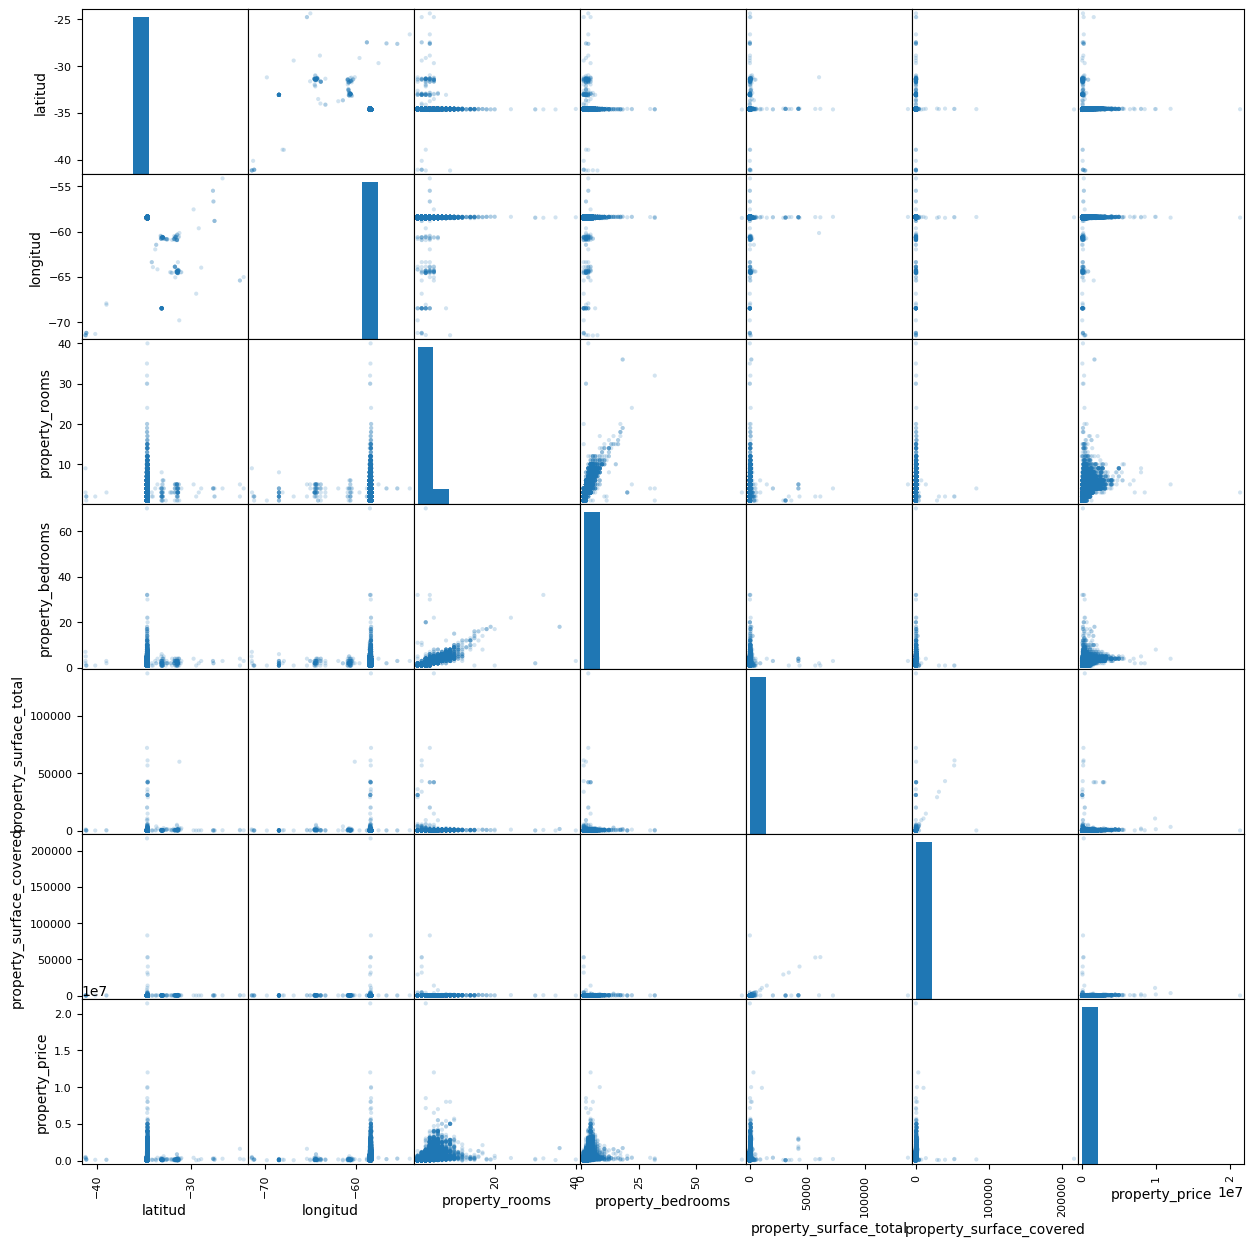

In [24]:
scatter_matrix(conjunto_entrenamiento_reducido.copy(), alpha=0.2, figsize= (15, 15))

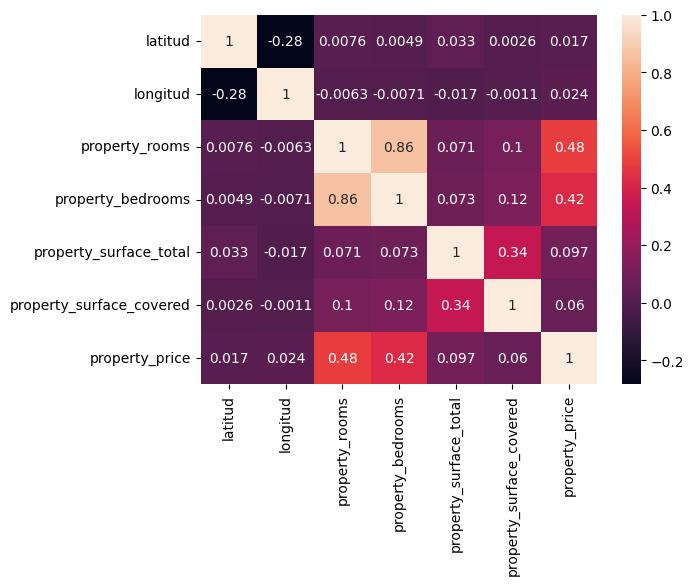

In [25]:
correlacion_matrix = conjunto_entrenamiento_reducido.select_dtypes(include=['float64', 'int64']).corr()
grafico_correlacion=sns.heatmap(correlacion_matrix,annot=True)

Podemos ver que existe una correlacion positiva importante entre property_rooms y property_bedrooms, que puede parecer logico ya que dormitorios representan la mayoria de las habitaciones de una propiedad. Ademas, podemos notar que existe una correlacion entre property_price, property_rooms y property_rooms, tambien parece logico ya que el precio de una propiedad depende en gran medida del numero de habitaciones.

Una correlacion positiva tambien parece existir entre property_surface_total y property_surface_covered porque en nucleos urbanos como Buenos Aires, la superficie cubierta por las propiedades suele ser ligeramente inferior o igual a la superficie total.

Por fin, hay una correlacion negativa entre latitud y longitud que se puede explicar con el hecho de que las limites de la ciudad son definidas geograficamente y no se pueden superar.

## b. Visualizacion de los datos

### Latitud - Longitud

Vamos a hacer dos box plot para esas variables y despues proponer un scatter plot para mostrar la correlacion entre la longitud y la longitud

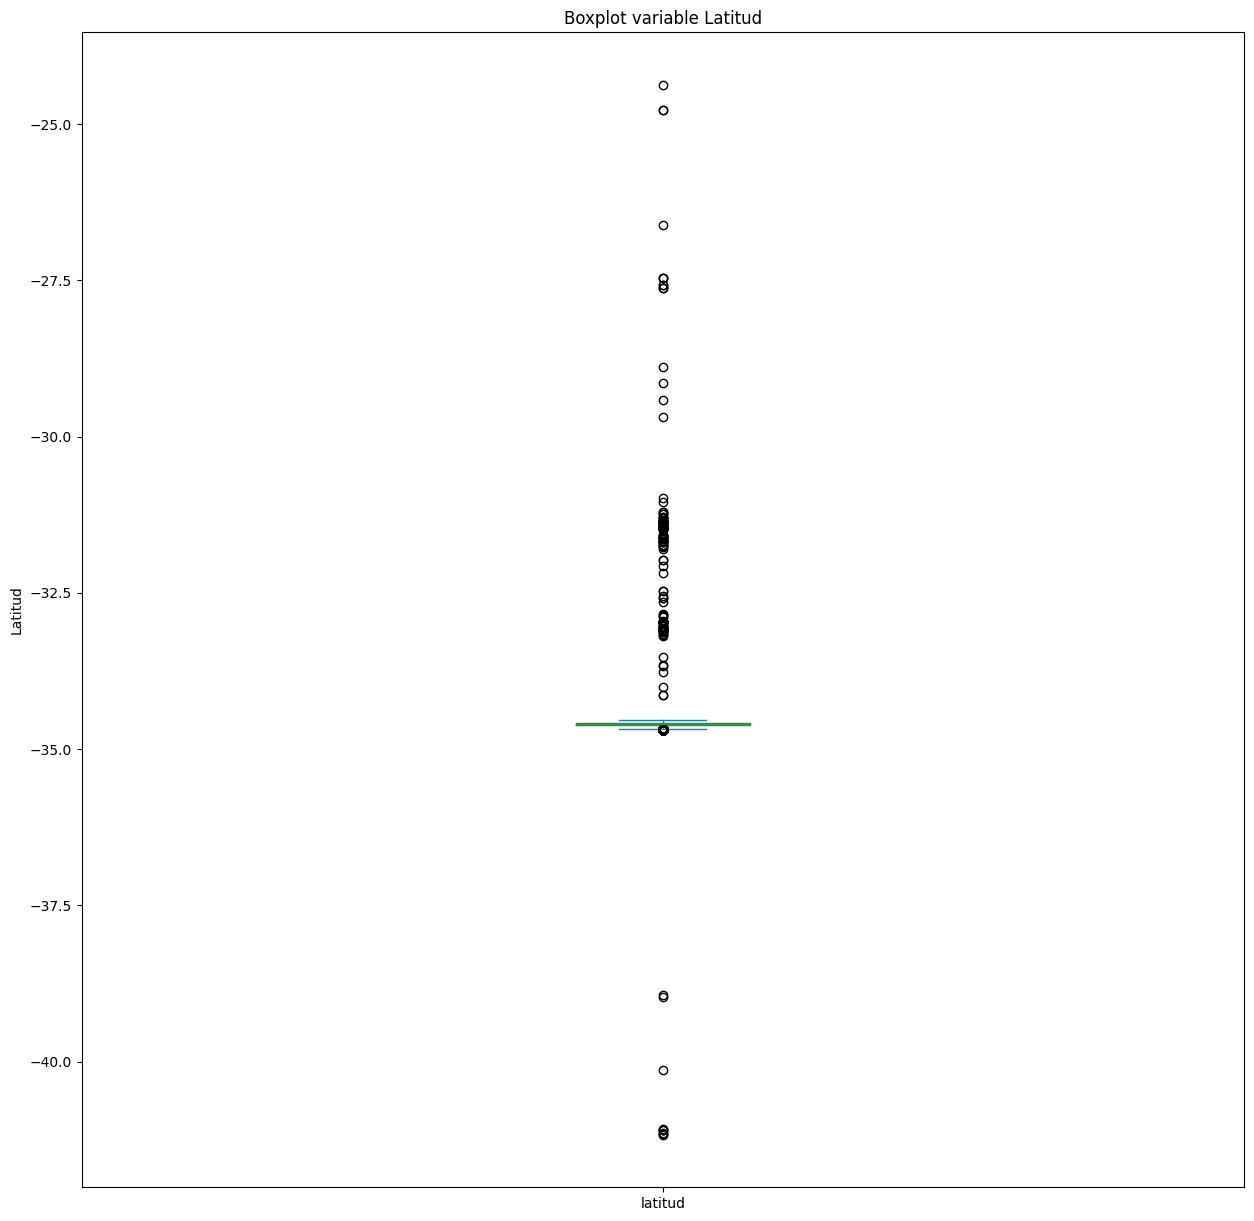

In [26]:
# Box Plot - Latitud

box_plot_latitud=conjunto_entrenamiento_reducido['latitud'].plot.box(title="Boxplot variable Latitud",
                               xlabel="",
                               ylabel="Latitud", figsize=(15,15))

Podemos ver que hay muchos valores atipicos para esta variable y que sera necesario tratarlos.

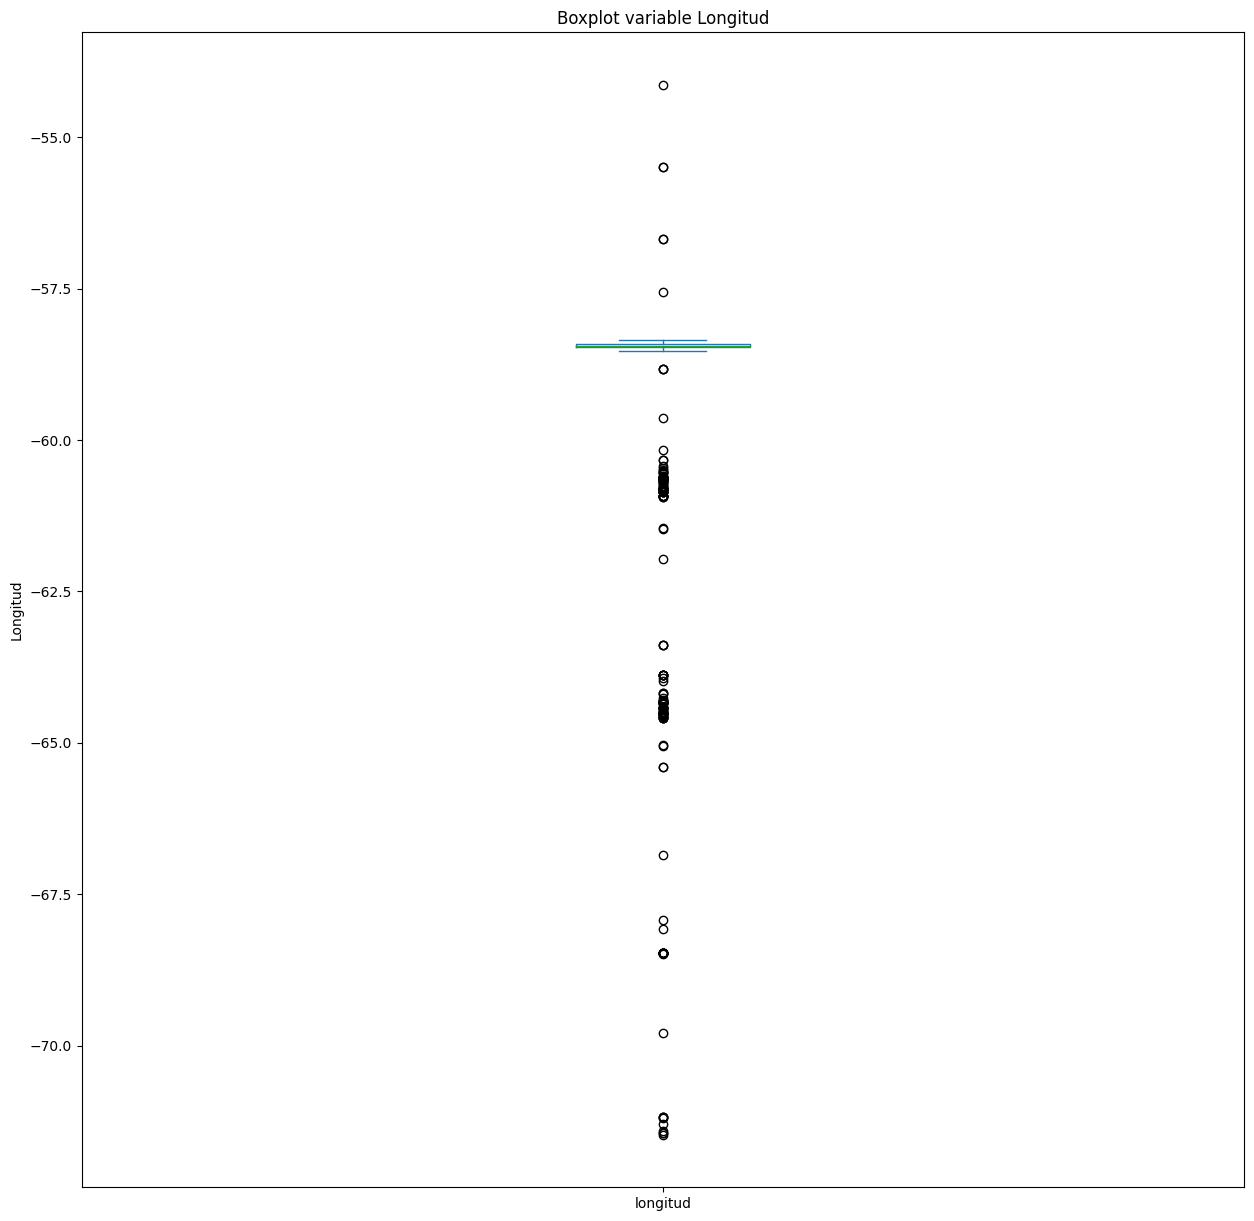

In [27]:
# Box Plot - Longitud

box_plot_longitud=conjunto_entrenamiento_reducido['longitud'].plot.box(title="Boxplot variable Longitud",
                               xlabel="",
                               ylabel="Longitud", figsize=(15,15))

Podemos hacer la misma conclusion con este variable y sus outliers.

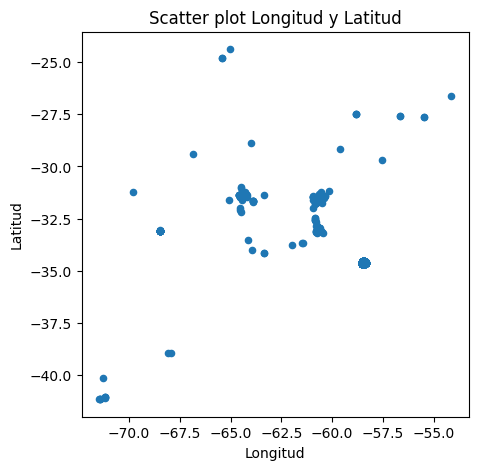

In [28]:
# Scatter plot - Latitud y Longitud

scatter_plot_longitud_latitud=conjunto_entrenamiento_reducido.plot.scatter(title="Scatter plot Longitud y Latitud",
                x='longitud', y='latitud',
                xlabel='Longitud', ylabel='Latitud',
                figsize=(5,5))

Podemos ver una gran concentracion de puntos en el centro del grafico, lo que puede corresponder a la posicion de las propiedades en la Capital Federal. Pero hay muchos valores atipicos, como anotado antes, que debemos eliminar o rectificar.

### Place_L3 - Place_L4

Vamos a hacer un grafico de barras para esas variables

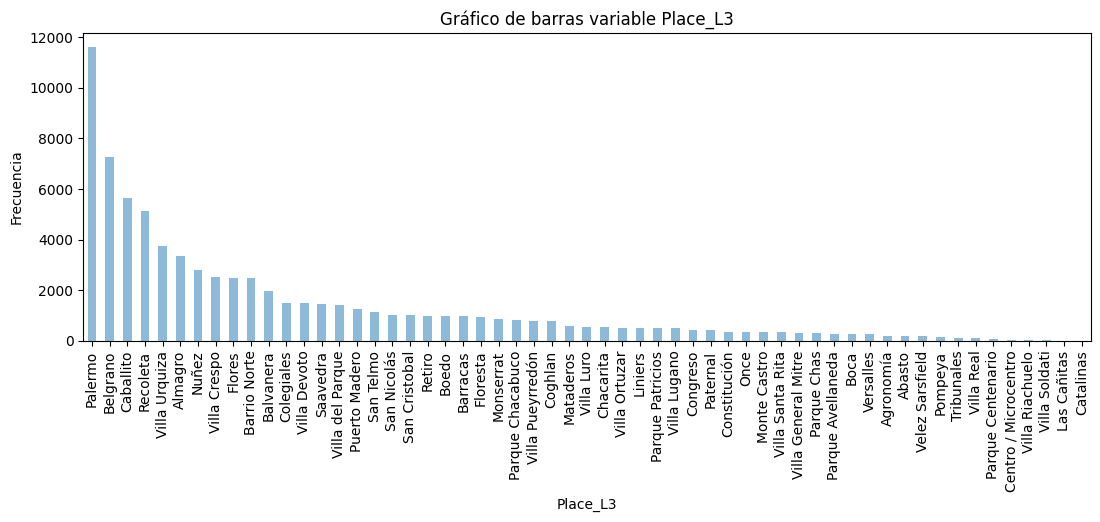

In [29]:
# Grafico de barras - Place_L3

barras_place_l3=conjunto_entrenamiento_reducido['place_l3'].value_counts().plot.bar(alpha=0.5,
                                                      title="Gráfico de barras variable Place_L3",
                                                      xlabel="Place_L3" ,
                                                      ylabel="Frecuencia",
                                                      figsize=(13,4))

Podemos ver una alta concentracion de las propiedades en Palermo, lo que vamos a verificar en una proxima parte con los puntos geograficos.

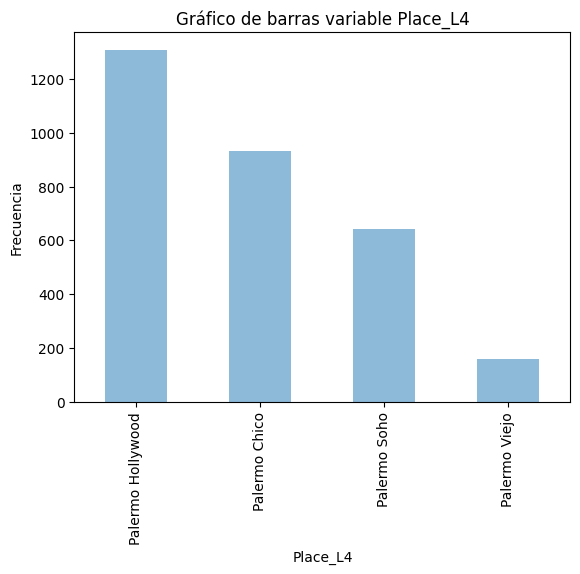

In [30]:
# Grafico de barras - Place_L4

barras_place_l4=conjunto_entrenamiento_reducido['place_l4'].value_counts().plot.bar(alpha=0.5,
                                                      title="Gráfico de barras variable Place_L4",
                                                      xlabel="Place_L4" ,
                                                      ylabel="Frecuencia")

### Property Type

Vamos a hacer un grafico de barras para esa variable

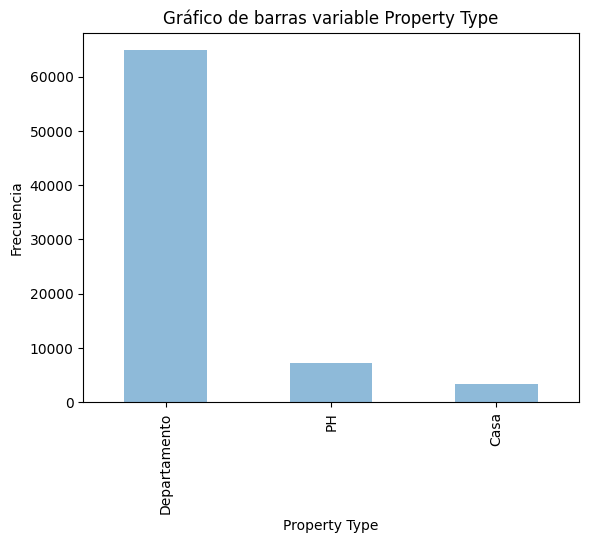

In [31]:
# Grafico de barras - Property Type

barras_property_type=conjunto_entrenamiento_reducido['property_type'].value_counts().plot.bar(alpha=0.5,
                                                      title="Gráfico de barras variable Property Type",
                                                      xlabel="Property Type" ,
                                                      ylabel="Frecuencia")

La mayoria de las propiedades son departamento, por lo que las estimaciones de precios para PH y casas no seran tan exactas.

### Property Surface Total - Property Surface Covered

Vamos a hacer por cada variable un grafico de densidad y un box plot para ver la distribucion total de los valores y para ver si existen outliers. Tambien, como las variables parecen correladas, vamos a hacer un scatter plot entre los dos.

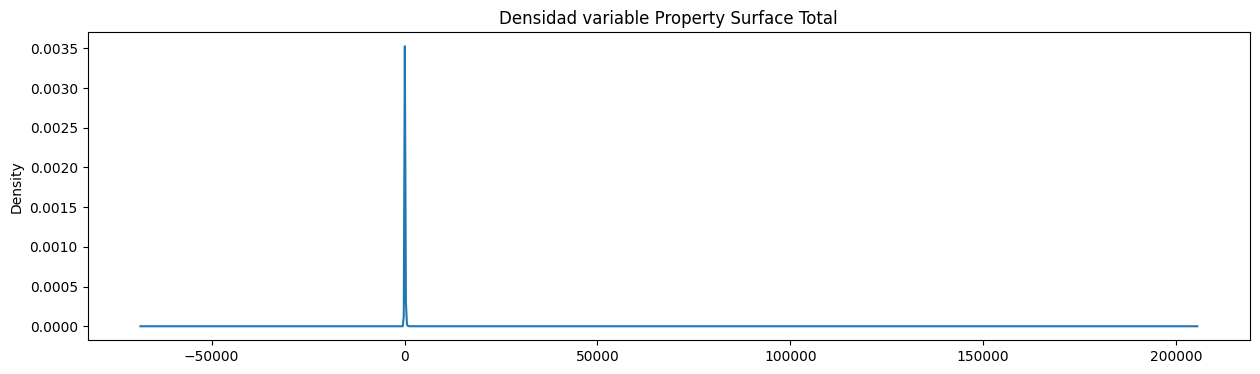

In [32]:
# Grafico de densidad - Property Surface Total

densidad_property_surface_total=conjunto_entrenamiento_reducido['property_surface_total'].plot.kde(title="Densidad variable Property Surface Total",xlabel="Property Surface Total",ylabel="Densidad", figsize=(15,4))

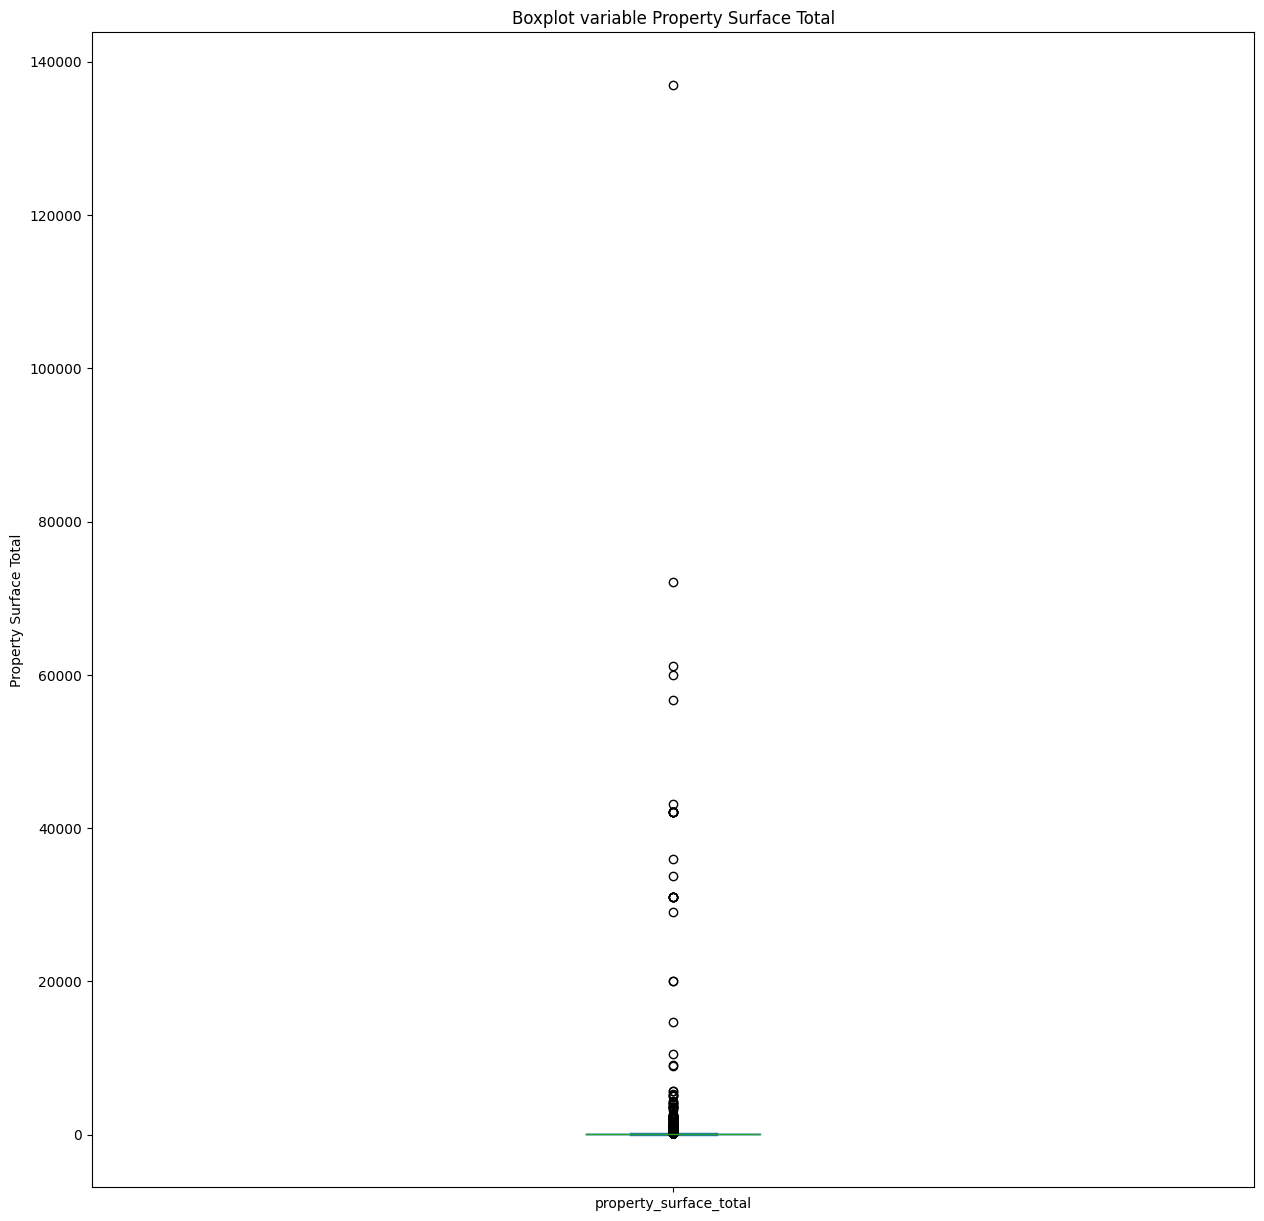

In [33]:
# Box Plot - Property Surface Total

box_plot_property_surface_total=conjunto_entrenamiento_reducido['property_surface_total'].plot.box(title="Boxplot variable Property Surface Total",
                               xlabel="",
                               ylabel="Property Surface Total", figsize=(15,15))

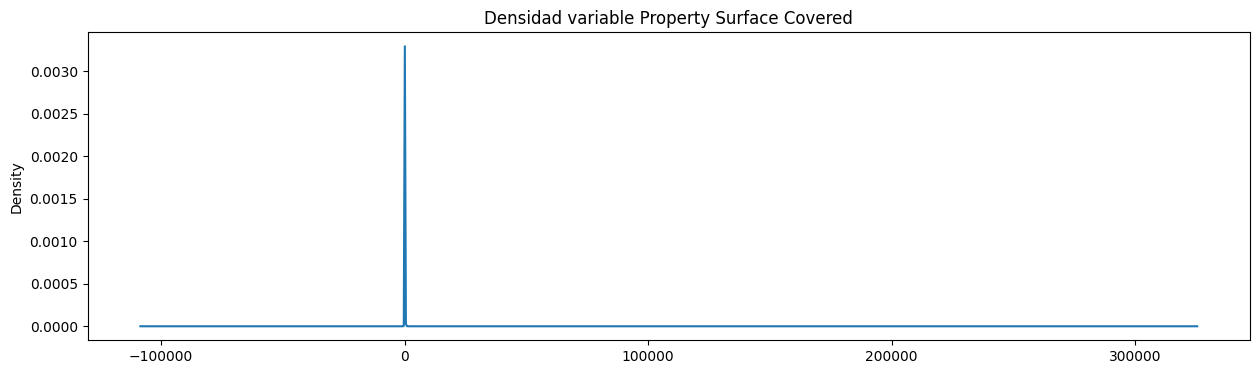

In [34]:
# Grafico de densidad - Property Surface Covered

densidad_property_surface_covered=conjunto_entrenamiento_reducido['property_surface_covered'].plot.kde(title="Densidad variable Property Surface Covered",xlabel="Property Surface Covered",ylabel="Densidad", figsize=(15,4))

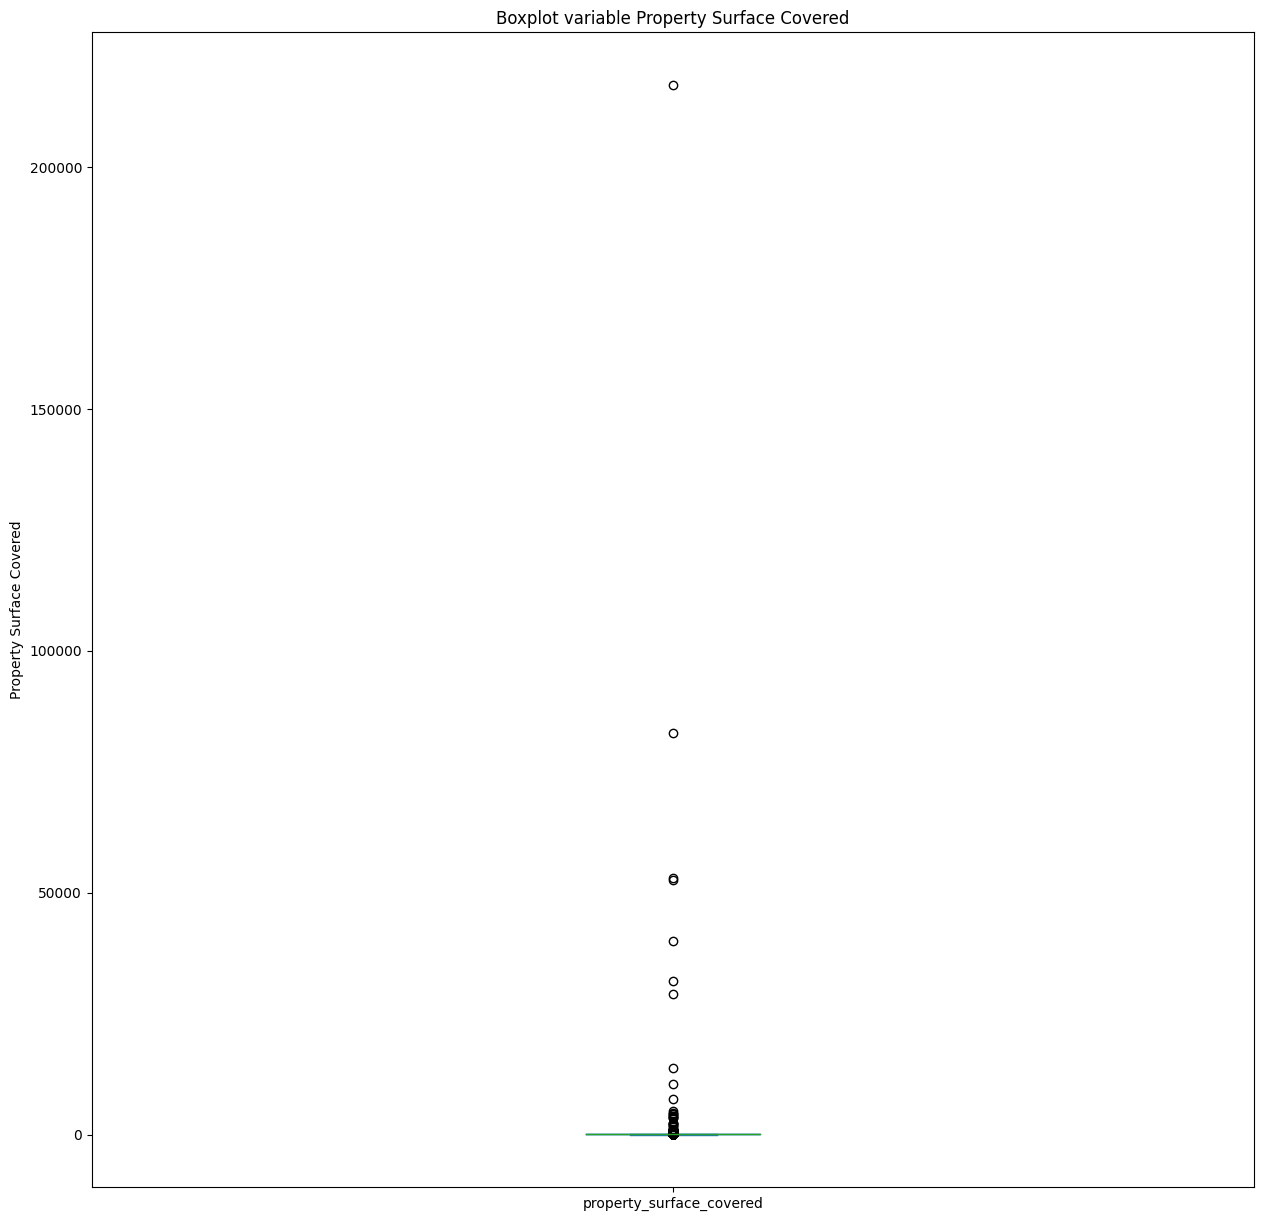

In [35]:
# Box Plot - Property Surface Covered

box_plot_property_surface_covered=conjunto_entrenamiento_reducido['property_surface_covered'].plot.box(title="Boxplot variable Property Surface Covered",
                               xlabel="",
                               ylabel="Property Surface Covered", figsize=(15,15))

Es muy dificil hacer conclusiones sobre esas variables, necesitamos tratarlas para tener una distribucion mas adecuada.

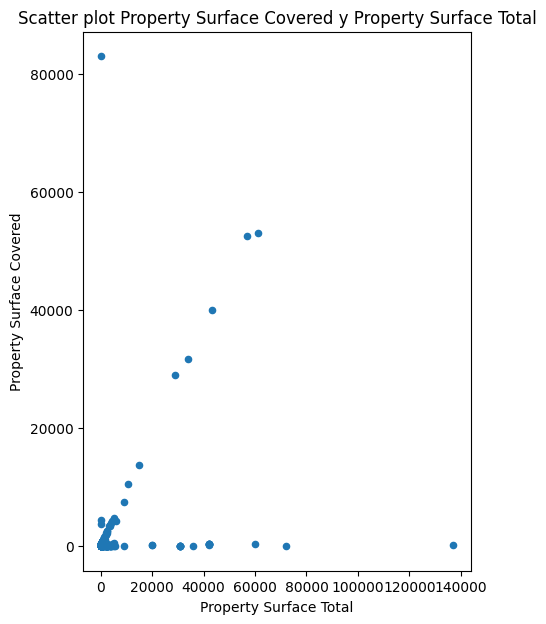

In [36]:
# Scatter plot - Property Surface Covered y Property Surface Total

scatter_plot_property_surface_covered_total=conjunto_entrenamiento_reducido.plot.scatter(title="Scatter plot Property Surface Covered y Property Surface Total",
                x='property_surface_total', y='property_surface_covered',
                xlabel='Property Surface Total', ylabel='Property Surface Covered',
                figsize=(5,7))

Hay entonces una correlacion linear positiva entre esas variables.

### Property Rooms - Property Bedrooms

Vamos a hacer por cada variable un histograma para ver la distribucion de manera discreta (porque los valores son enteros). Tambien, como las variables parecen correladas, vamos a hacer un scatter plot entre los dos.

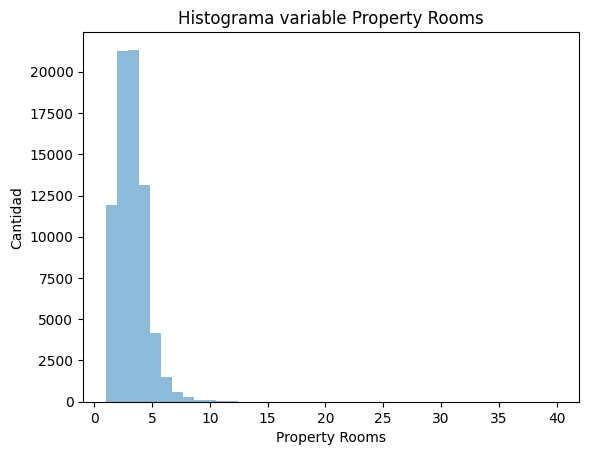

In [37]:
# Histograma - Property Rooms

hist_property_rooms=conjunto_entrenamiento_reducido['property_rooms'].plot.hist(alpha=0.5,bins=41,
                                                                                title="Histograma variable Property Rooms",
                                                                                      xlabel="Property Rooms",
                                                                                      ylabel="Cantidad")

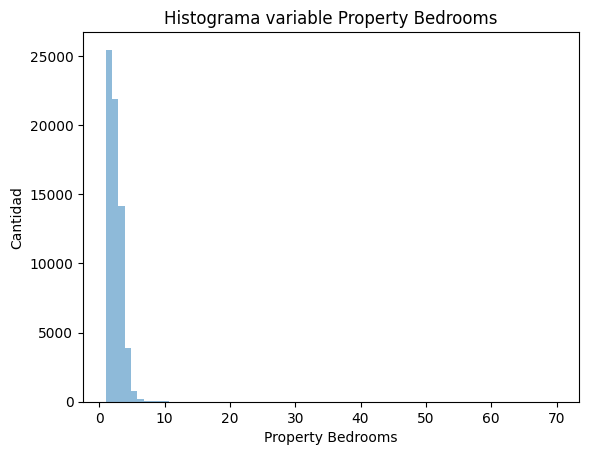

In [38]:
# Histograma - Property Bedrooms

hist_property_bedrooms=conjunto_entrenamiento_reducido['property_bedrooms'].plot.hist(alpha=0.5, bins=71,
                                                                                      title="Histograma variable Property Bedrooms",
                                                                                      xlabel="Property Bedrooms",
                                                                                      ylabel="Cantidad")

La mayoria de las propiedades tienen de 1 a 4 habitaciones con 1 a 3 dormitorios.

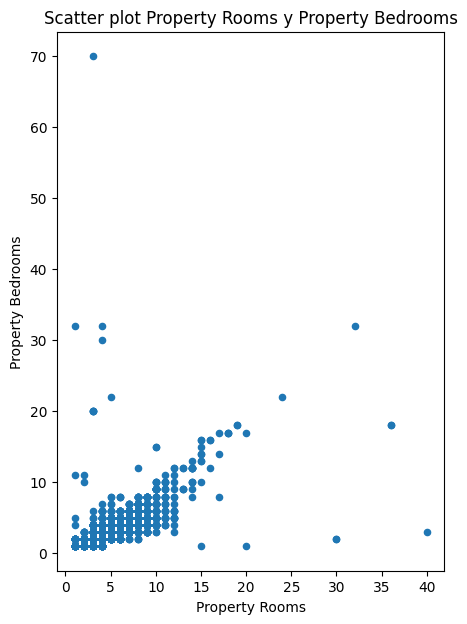

In [39]:
# Scatter plot - Property Rooms y Property Bedrooms

scatter_plot_property_rooms_bedrooms=conjunto_entrenamiento_reducido.plot.scatter(title="Scatter plot Property Rooms y Property Bedrooms",
                x='property_rooms', y='property_bedrooms',
                xlabel='Property Rooms', ylabel='Property Bedrooms',
                figsize=(5,7))

Hay entonces una correlacion linear positiva entre esas variables.


Podemos tambien hacer dos scatter plot entre Property Rooms y Property Price, y entre Property Bedrooms y Property Price, para verificar que existe correlaciones lineares.

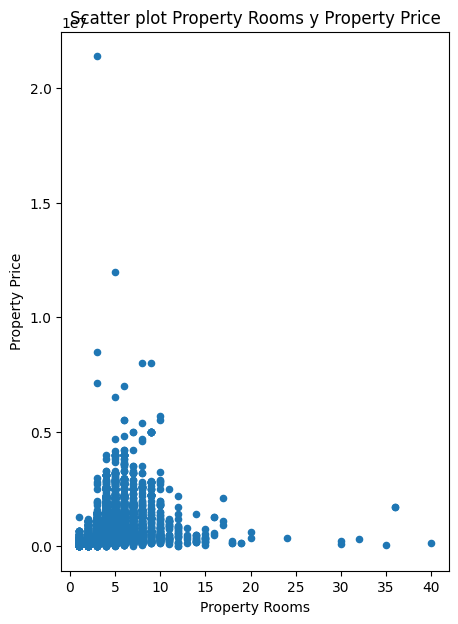

In [40]:
# Scatter plot - Property Rooms y Property Price

scatter_plot_property_rooms_price=conjunto_entrenamiento_reducido.plot.scatter(title="Scatter plot Property Rooms y Property Price",
                x='property_rooms', y='property_price',
                xlabel='Property Rooms', ylabel='Property Price',
                figsize=(5,7))

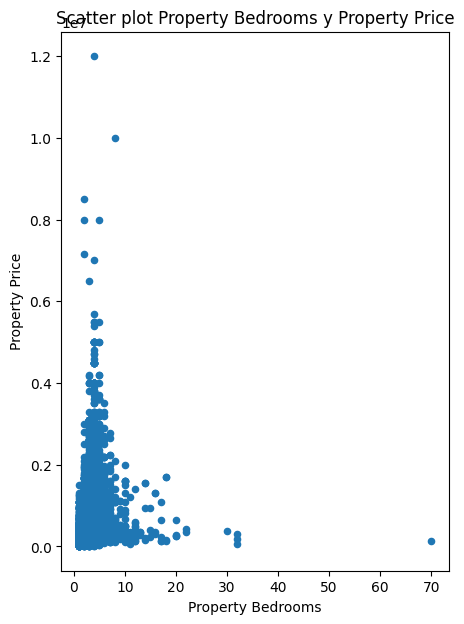

In [41]:
# Scatter plot - Property Bedrooms y Property Price

scatter_plot_property_bedrooms_price=conjunto_entrenamiento_reducido.plot.scatter(title="Scatter plot Property Bedrooms y Property Price",
                x='property_bedrooms', y='property_price',
                xlabel='Property Bedrooms', ylabel='Property Price',
                figsize=(5,7))

Las correlaciones son mucho menos visibles, lo que se traduce en un coeficiente de correlacion mas bajo, como se ha senalado anteriormente.

### Property Price

Vamos a hacer un grafico de densidad y un box plot para ver la distribucion total de los valores y para ver si existen outliers.

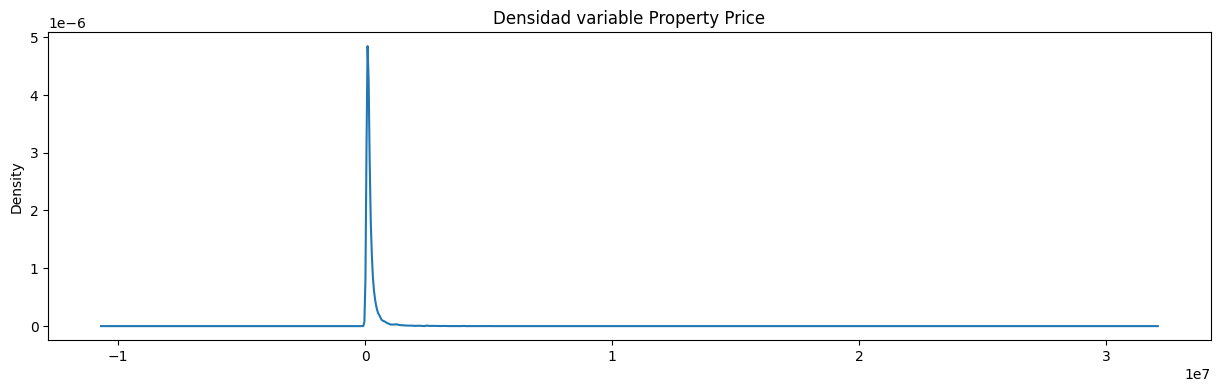

In [42]:
# Grafico de densidad - Property Price

densidad_property_price=conjunto_entrenamiento_reducido['property_price'].plot.kde(title="Densidad variable Property Price",xlabel="Property Price",ylabel="Densidad", figsize=(15,4))

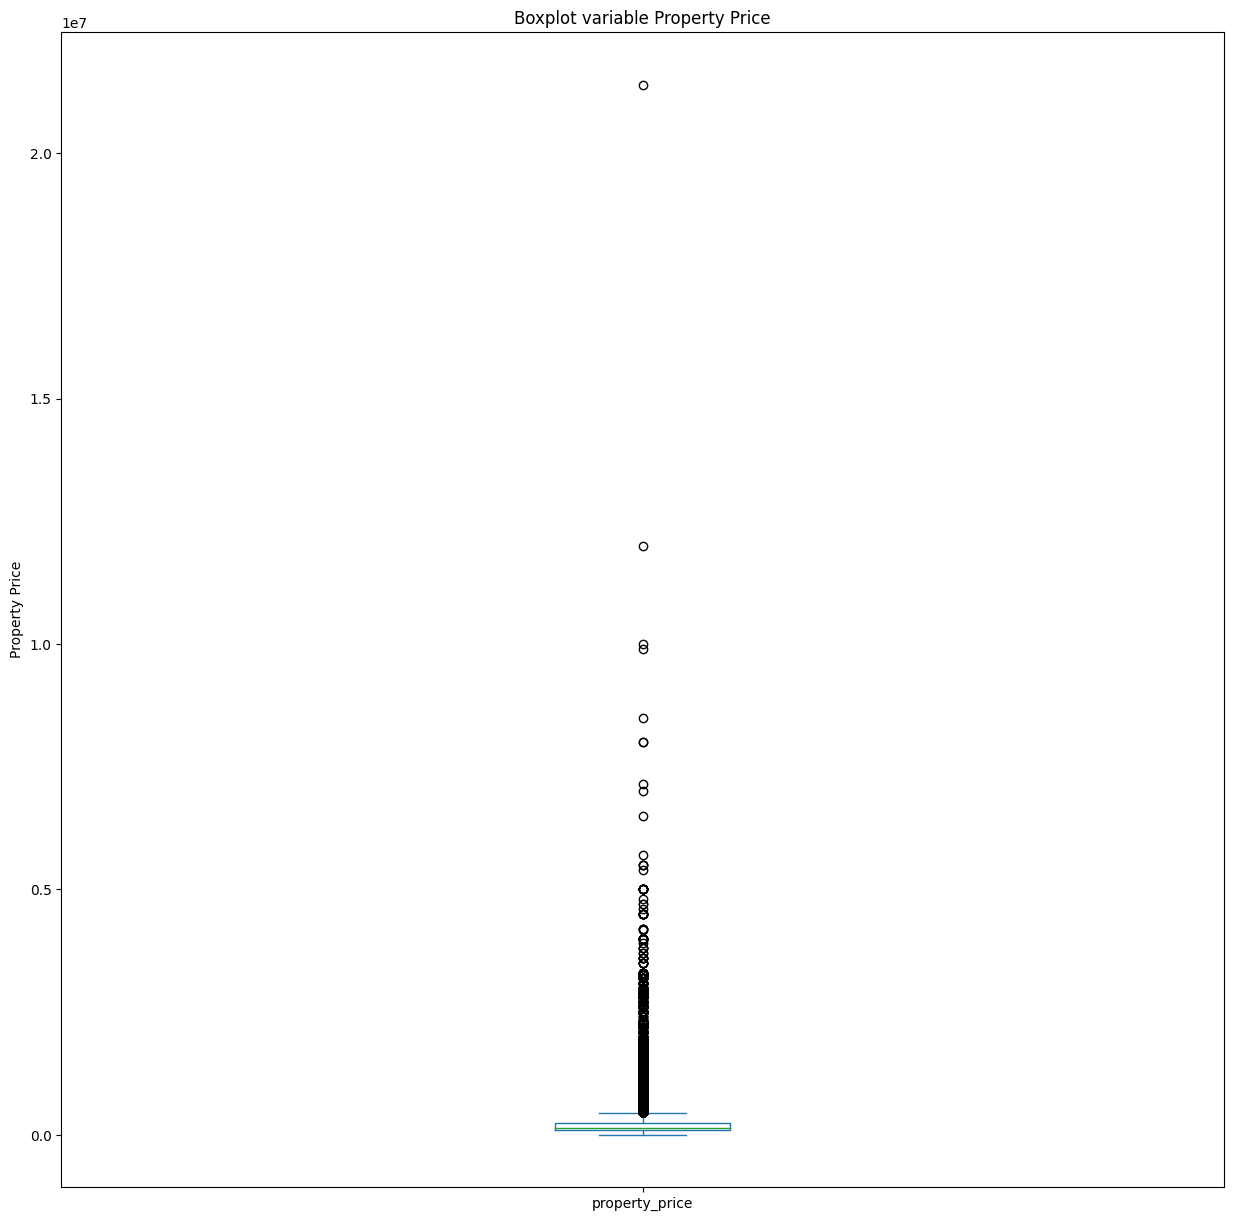

In [43]:
# Box Plot - Property Price

box_plot_property_price=conjunto_entrenamiento_reducido['property_price'].plot.box(title="Boxplot variable Property Price",
                               xlabel="",
                               ylabel="Property Price", figsize=(15,15))

Es tambien dificil de hacer conclusiones, pero la mayoria de los precios estan debajo de 100 000$.

## c. Datos faltantes

### Analisis a nivel de columna

latitud                      4.210931
longitud                     4.210931
place_l3                     0.477460
place_l4                    95.966790
property_type                0.000000
property_rooms               1.141925
property_bedrooms           11.740209
property_surface_total       5.535882
property_surface_covered     3.817027
property_price               0.000000
dtype: float64


<AxesSubplot:title={'center':'Grafico de barras del porcentaje de datos faltantes por columna'}, xlabel='Variable', ylabel='Porcentaje'>

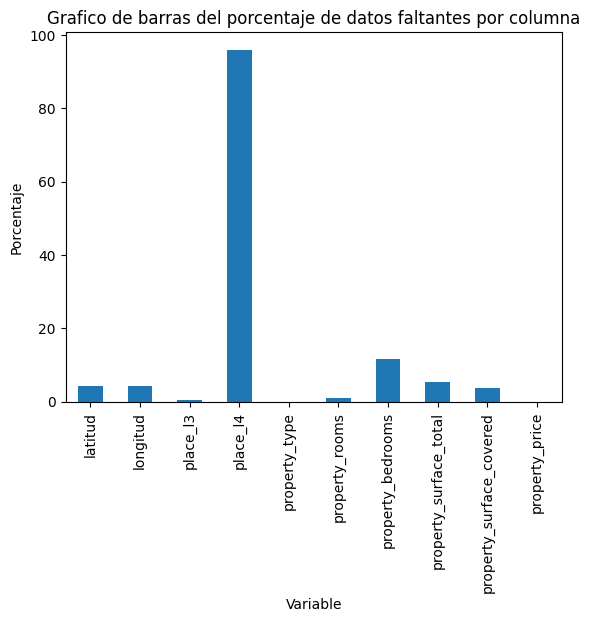

In [44]:
faltante_columna = conjunto_entrenamiento_reducido.isnull().mean()*100
print(faltante_columna)
faltante_columna.plot.bar(title="Grafico de barras del porcentaje de datos faltantes por columna",
                          xlabel="Variable", ylabel="Porcentaje")

### Analisis a nivel de fila

0        36.363636
1         9.090909
2         9.090909
3        18.181818
4        18.181818
           ...    
75394    18.181818
75395     9.090909
75396     9.090909
75397    18.181818
75398     9.090909
Length: 75399, dtype: float64
Promedia de datos faltantes por fila :  11.554650471612238


<AxesSubplot:title={'center':'Grafico de barras del porcentaje de datos faltantes por fila'}, xlabel='Fila', ylabel='Porcentaje'>

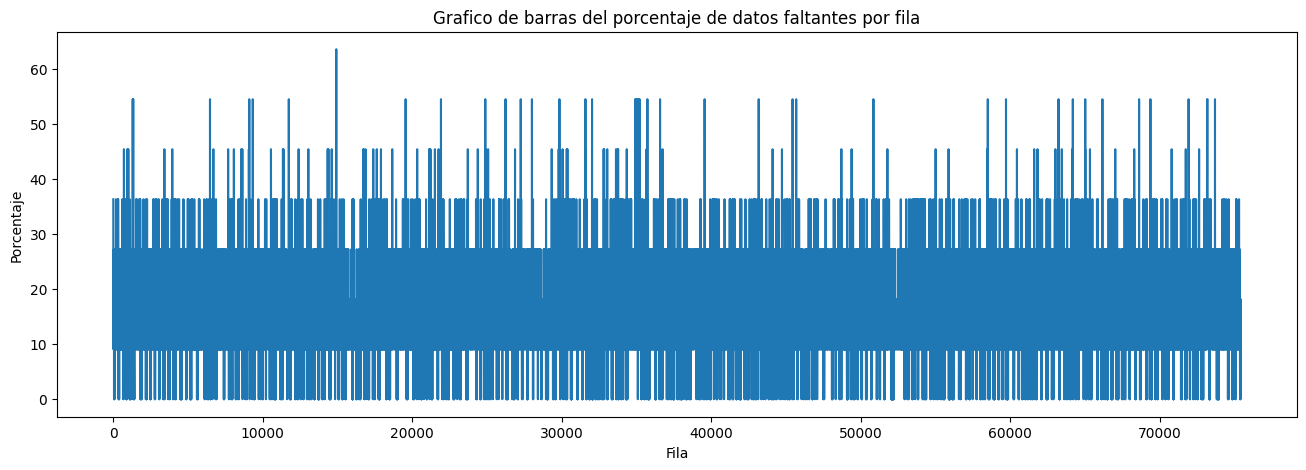

In [45]:
faltante_fila = conjunto_entrenamiento_reducido.reset_index().isnull().mean(axis=1)*100
print(faltante_fila)
print("Promedia de datos faltantes por fila : ", faltante_fila.mean())
faltante_fila.plot(figsize=(16,5), title="Grafico de barras del porcentaje de datos faltantes por fila",
                          xlabel="Fila", ylabel="Porcentaje")

### Revision de los datos faltantes

Hemos visto que falta valores en las columnas Latitud, Longitud, Place_L3, Place_L4, Property Rooms, Property Bedrooms, Property Surface Total, Property Surface Covered. Vamos a modificar los valores que faltan segun los siguientes ejes :

- Latitud/Longitud: vamos a utilizar un CSV que delimita todos los barrios de Capital Federal (que estan representados en Place L3) para recuperar el centro del barrio (si se ha definido en el Place_L3) como coordenadas de la propiedad
- Place_L3: vamos a hacer lo contrario para deducir el barrio desde las coordenadas
- Place_L4: esta variable solo representa las subdivisiones del barrio de Palermo, asi que vamos a eliminarla e integrarla directamente en la variable Place_L3
- Property Rooms, Property Bedrooms, Property Surface Total, Property Surface Covered : utilizaremos el principio MICE (Multivariate Imputation by Chained Equations) para imputar las valores faltantes por regresion

#### Latitud - Longitud

In [46]:
# Importado del CSV
barrios = pd.read_csv("Datasets/barrios.csv", sep=";")
barrios['centro'] = barrios['WKT'].apply(lambda x: loads(x).centroid)
barrios['longitud'] = barrios['centro'].apply(lambda point: point.x)
barrios['latitud'] = barrios['centro'].apply(lambda point: point.y)
barrios.drop(columns=["COMUNA", "PERIMETRO", "AREA", "OBJETO", "centro"], inplace=True)
barrios

,WKT,BARRIO,longitud,latitud
0,MULTIPOLYGON (((-58.4528200492791 -34.59598865...,CHACARITA,-58.454180,-34.588369
1,MULTIPOLYGON (((-58.4655768128541 -34.59655770...,PATERNAL,-58.468665,-34.597421
2,MULTIPOLYGON (((-58.4237529813037 -34.59782733...,VILLA CRESPO,-58.442725,-34.598830
3,MULTIPOLYGON (((-58.4946097568899 -34.61486523...,VILLA DEL PARQUE,-58.490677,-34.604247
4,MULTIPOLYGON (((-58.4128700313088 -34.61411625...,ALMAGRO,-58.421745,-34.609227
5,MULTIPOLYGON (((-58.4306058283309 -34.60704708...,CABALLITO,-58.443603,-34.616825
6,MULTIPOLYGON (((-58.4819203599833 -34.62428717...,VILLA SANTA RITA,-58.482957,-34.616193
7,MULTIPOLYGON (((-58.5034920611534 -34.62403242...,MONTE CASTRO,-58.506581,-34.619298
8,MULTIPOLYGON (((-58.525116079791 -34.613999981...,VILLA REAL,-58.526039,-34.619493
9,MULTIPOLYGON (((-58.4604133778842 -34.65679784...,FLORES,-58.458268,-34.636803


In [47]:
# Imputacion desde el centro de los barrios
conjunto_entrenamiento_sin_faltantes = conjunto_entrenamiento_reducido.copy()
faltantes_latitud_antes = conjunto_entrenamiento_reducido[conjunto_entrenamiento_reducido["latitud"].isna()].shape[0]
faltantes_longitud_antes = conjunto_entrenamiento_reducido[conjunto_entrenamiento_reducido["longitud"].isna()].shape[0]

for i in range(conjunto_entrenamiento_sin_faltantes.shape[0]) :
    latitud = conjunto_entrenamiento_sin_faltantes.iloc[i,0]
    longitud = conjunto_entrenamiento_sin_faltantes.iloc[i,1]
    barrio = conjunto_entrenamiento_sin_faltantes.iloc[i,2]

    if pd.isnull(latitud) and pd.notnull(barrio) and barrios[barrios["BARRIO"] == barrio.upper()].shape[0] > 0 :
        conjunto_entrenamiento_sin_faltantes.iloc[i,0] = barrios[barrios["BARRIO"] == barrio.upper()]["latitud"].values[0]

    if pd.isnull(longitud) and pd.notnull(barrio) and barrios[barrios["BARRIO"] == barrio.upper()].shape[0] > 0 :
        conjunto_entrenamiento_sin_faltantes.iloc[i,1] = barrios[barrios["BARRIO"] == barrio.upper()]["longitud"].values[0]

faltantes_latitud_despues = conjunto_entrenamiento_sin_faltantes[conjunto_entrenamiento_sin_faltantes["latitud"].isna()].shape[0]
faltantes_longitud_despues = conjunto_entrenamiento_sin_faltantes[conjunto_entrenamiento_sin_faltantes["longitud"].isna()].shape[0]

print("Reduccion de datos faltantes sobre la latitud : ", (faltantes_latitud_antes - faltantes_latitud_despues)/faltantes_latitud_antes * 100, "%")
print("Reduccion de datos faltantes sobre la longitud : ", (faltantes_longitud_antes - faltantes_longitud_despues)/faltantes_longitud_antes * 100, "%")

conjunto_entrenamiento_sin_faltantes

Reduccion de datos faltantes sobre la latitud :  85.41732283464567 %
Reduccion de datos faltantes sobre la longitud :  85.41732283464567 %


,latitud,longitud,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
25,NaN,NaN,NaN,NaN,Casa,4.0,3.0,171.0,133.0,210000.0
42,-34.637319,-58.361124,Boca,NaN,Departamento,3.0,2.0,58.0,55.0,82900.0
43,-34.628647,-58.361871,Boca,NaN,Departamento,4.0,3.0,70.0,70.0,99000.0
49,-34.610027,-58.401934,Once,NaN,Departamento,4.0,2.0,NaN,104.0,146000.0
51,-34.631621,-58.416825,Boedo,NaN,PH,4.0,2.0,NaN,73.0,250000.0
...,...,...,...,...,...,...,...,...,...,...
372671,-34.582800,-58.442800,Palermo,NaN,Departamento,1.0,NaN,36.0,32.0,98514.0
372672,-34.590332,-58.420135,Palermo,NaN,Departamento,4.0,3.0,81.0,72.0,200000.0
372673,-34.576232,-58.441949,Palermo,NaN,Departamento,3.0,2.0,62.0,57.0,130000.0
372674,-34.582800,-58.442800,Palermo,NaN,Departamento,1.0,NaN,36.0,32.0,100273.0


#### Place_L3 - Place_L4

In [48]:
# Eliminacion de la columna Place_L4

conjunto_entrenamiento_sin_faltantes.loc[conjunto_entrenamiento_sin_faltantes["place_l4"].notnull(), "place_l3"] = conjunto_entrenamiento_sin_faltantes["place_l4"]
conjunto_entrenamiento_sin_faltantes.drop(columns=["place_l4"], inplace=True)
conjunto_entrenamiento_sin_faltantes

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
25,NaN,NaN,NaN,Casa,4.0,3.0,171.0,133.0,210000.0
42,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.0,55.0,82900.0
43,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.0,70.0,99000.0
49,-34.610027,-58.401934,Once,Departamento,4.0,2.0,NaN,104.0,146000.0
51,-34.631621,-58.416825,Boedo,PH,4.0,2.0,NaN,73.0,250000.0
...,...,...,...,...,...,...,...,...,...
372671,-34.582800,-58.442800,Palermo,Departamento,1.0,NaN,36.0,32.0,98514.0
372672,-34.590332,-58.420135,Palermo,Departamento,4.0,3.0,81.0,72.0,200000.0
372673,-34.576232,-58.441949,Palermo,Departamento,3.0,2.0,62.0,57.0,130000.0
372674,-34.582800,-58.442800,Palermo,Departamento,1.0,NaN,36.0,32.0,100273.0


In [49]:
# Imputacion sobre las cordenadas

faltantes_barrio_antes = conjunto_entrenamiento_reducido[conjunto_entrenamiento_reducido["place_l3"].isna()].shape[0]

for i in range(conjunto_entrenamiento_sin_faltantes.shape[0]) :
    latitud = conjunto_entrenamiento_sin_faltantes.iloc[i,0]
    longitud = conjunto_entrenamiento_sin_faltantes.iloc[i,1]
    barrio = conjunto_entrenamiento_sin_faltantes.iloc[i,2]

    if pd.notnull(latitud) and pd.notnull(longitud) and pd.isnull(barrio) :

        punto = Point(longitud, latitud)
        barrio_del_punto = None
        for idx, row in barrios.iterrows():
            polygono = loads(row['WKT'])
            if polygono.contains(punto):
                barrio_del_punto = row['BARRIO'].title()
                break

        conjunto_entrenamiento_sin_faltantes.iloc[i,2] = barrio_del_punto

faltantes_barrio_despues = conjunto_entrenamiento_sin_faltantes[conjunto_entrenamiento_sin_faltantes["place_l3"].isna()].shape[0]

print("Reduccion de datos faltantes sobre el barrio : ", (faltantes_barrio_antes - faltantes_barrio_despues)/faltantes_barrio_antes * 100, "%")

conjunto_entrenamiento_sin_faltantes

Reduccion de datos faltantes sobre el barrio :  11.944444444444445 %


,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
25,NaN,NaN,NaN,Casa,4.0,3.0,171.0,133.0,210000.0
42,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.0,55.0,82900.0
43,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.0,70.0,99000.0
49,-34.610027,-58.401934,Once,Departamento,4.0,2.0,NaN,104.0,146000.0
51,-34.631621,-58.416825,Boedo,PH,4.0,2.0,NaN,73.0,250000.0
...,...,...,...,...,...,...,...,...,...
372671,-34.582800,-58.442800,Palermo,Departamento,1.0,NaN,36.0,32.0,98514.0
372672,-34.590332,-58.420135,Palermo,Departamento,4.0,3.0,81.0,72.0,200000.0
372673,-34.576232,-58.441949,Palermo,Departamento,3.0,2.0,62.0,57.0,130000.0
372674,-34.582800,-58.442800,Palermo,Departamento,1.0,NaN,36.0,32.0,100273.0


#### Property Rooms - Property Bedrooms - Property Surface Covered - Property Surface Total

In [50]:
columnas_a_completar = conjunto_entrenamiento_sin_faltantes[["property_bedrooms", "property_rooms", "property_surface_covered", "property_surface_total"]]
faltantes_bedrooms_antes = conjunto_entrenamiento_reducido[conjunto_entrenamiento_reducido["property_bedrooms"].isna()].shape[0]
faltantes_rooms_antes = conjunto_entrenamiento_reducido[conjunto_entrenamiento_reducido["property_rooms"].isna()].shape[0]
faltantes_s_covered_antes = conjunto_entrenamiento_reducido[conjunto_entrenamiento_reducido["property_surface_covered"].isna()].shape[0]
faltantes_s_total_antes = conjunto_entrenamiento_reducido[conjunto_entrenamiento_reducido["property_surface_total"].isna()].shape[0]

lr = LinearRegression()
imp = IterativeImputer(
    estimator=lr, missing_values=np.nan, max_iter=20, verbose=0, random_state=0
)
columnas_completadas = pd.DataFrame(np.round(imp.fit_transform(columnas_a_completar)), columns=["property_bedrooms", "property_rooms", "property_surface_covered", "property_surface_total"])

conjunto_entrenamiento_sin_faltantes_final = pd.concat([
    conjunto_entrenamiento_sin_faltantes[["latitud", "longitud", "place_l3", "property_type"]].reset_index(drop=True),
    columnas_completadas.reset_index(drop=True),
    conjunto_entrenamiento_sin_faltantes["property_price"].reset_index(drop=True)], axis=1)


faltantes_bedrooms_despues = conjunto_entrenamiento_sin_faltantes_final[conjunto_entrenamiento_sin_faltantes_final["property_bedrooms"].isna()].shape[0]
faltantes_rooms_despues = conjunto_entrenamiento_sin_faltantes_final[conjunto_entrenamiento_sin_faltantes_final["property_rooms"].isna()].shape[0]
faltantes_s_covered_despues = conjunto_entrenamiento_sin_faltantes_final[conjunto_entrenamiento_sin_faltantes_final["property_surface_covered"].isna()].shape[0]
faltantes_s_total_despues = conjunto_entrenamiento_sin_faltantes_final[conjunto_entrenamiento_sin_faltantes_final["property_surface_total"].isna()].shape[0]

print("Reduccion de datos faltantes sobre el numero de dormitorios : ", (faltantes_bedrooms_antes - faltantes_bedrooms_despues)/faltantes_bedrooms_antes * 100, "%")
print("Reduccion de datos faltantes sobre el numero de habitaciones : ", (faltantes_rooms_antes - faltantes_rooms_despues)/faltantes_rooms_antes * 100, "%")
print("Reduccion de datos faltantes sobre la superficie cubierta : ", (faltantes_s_covered_antes - faltantes_s_covered_despues)/faltantes_s_covered_antes * 100, "%")
print("Reduccion de datos faltantes sobre la superficie total : ", (faltantes_s_total_antes - faltantes_s_total_despues)/faltantes_s_total_antes * 100, "%")

conjunto_entrenamiento_sin_faltantes_final

Reduccion de datos faltantes sobre el numero de dormitorios :  100.0 %
Reduccion de datos faltantes sobre el numero de habitaciones :  100.0 %
Reduccion de datos faltantes sobre la superficie cubierta :  100.0 %
Reduccion de datos faltantes sobre la superficie total :  100.0 %


,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price
0,NaN,NaN,NaN,Casa,3.0,4.0,133.0,171.0,210000.0
1,-34.637319,-58.361124,Boca,Departamento,2.0,3.0,55.0,58.0,82900.0
2,-34.628647,-58.361871,Boca,Departamento,3.0,4.0,70.0,70.0,99000.0
3,-34.610027,-58.401934,Once,Departamento,2.0,4.0,104.0,138.0,146000.0
4,-34.631621,-58.416825,Boedo,PH,2.0,4.0,73.0,118.0,250000.0
...,...,...,...,...,...,...,...,...,...
75394,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,98514.0
75395,-34.590332,-58.420135,Palermo,Departamento,3.0,4.0,72.0,81.0,200000.0
75396,-34.576232,-58.441949,Palermo,Departamento,2.0,3.0,57.0,62.0,130000.0
75397,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,100273.0


### Analisis final

latitud                     0.614066
longitud                    0.614066
place_l3                    0.420430
property_type               0.000000
property_bedrooms           0.000000
property_rooms              0.000000
property_surface_covered    0.000000
property_surface_total      0.000000
property_price              0.000000
dtype: float64


<AxesSubplot:title={'center':'Grafico de barras del porcentaje de datos faltantes por columna despues de la imputacion'}, xlabel='Variable', ylabel='Porcentaje'>

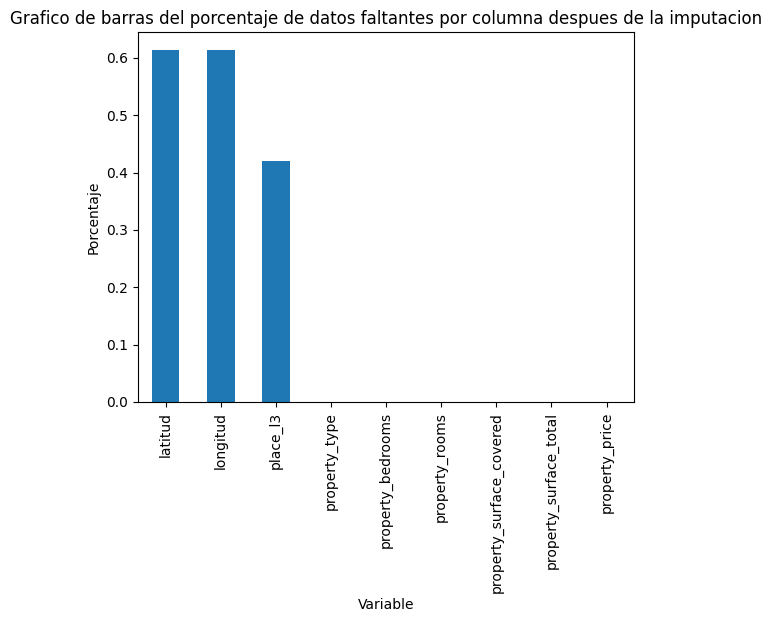

In [51]:
faltante_columna_final = conjunto_entrenamiento_sin_faltantes_final.isnull().mean()*100
print(faltante_columna_final)
faltante_columna_final.plot.bar(title="Grafico de barras del porcentaje de datos faltantes por columna despues de la imputacion",
                          xlabel="Variable", ylabel="Porcentaje")

Podemos ver que sigue faltando una pequena cantidad de datos en las variables latitud, longitud y place_l3, pero que sigue siendo muy pequena en comparacion con lo que teniamos anteriormente, por lo que hemos decidido eliminar las filas en las que faltan estos datos, ya que la cantidad es relativamente pequena en comparacion con el dataset entero.

In [52]:
conjunto_entrenamiento_sin_faltantes_final.dropna(inplace=True)
conjunto_entrenamiento_sin_faltantes_final

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price
1,-34.637319,-58.361124,Boca,Departamento,2.0,3.0,55.0,58.0,82900.0
2,-34.628647,-58.361871,Boca,Departamento,3.0,4.0,70.0,70.0,99000.0
3,-34.610027,-58.401934,Once,Departamento,2.0,4.0,104.0,138.0,146000.0
4,-34.631621,-58.416825,Boedo,PH,2.0,4.0,73.0,118.0,250000.0
5,-34.623886,-58.412746,Boedo,PH,1.0,2.0,46.0,61.0,100000.0
...,...,...,...,...,...,...,...,...,...
75394,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,98514.0
75395,-34.590332,-58.420135,Palermo,Departamento,3.0,4.0,72.0,81.0,200000.0
75396,-34.576232,-58.441949,Palermo,Departamento,2.0,3.0,57.0,62.0,130000.0
75397,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,100273.0


## d. Valores Atipicos

* Procedemos por identificar y analizar los outliers de forma unidimensional
* TODO : multidimensional

### Analisis unidimensional

#### Valores negativos

In [53]:
conjunto_entrenamiento_sin_faltantes_final['property_bedrooms'] = conjunto_entrenamiento_sin_faltantes_final['property_bedrooms'].abs()
conjunto_entrenamiento_sin_faltantes_final['property_rooms'] = conjunto_entrenamiento_sin_faltantes_final['property_rooms'].abs()
conjunto_entrenamiento_sin_faltantes_final['property_surface_covered'] = conjunto_entrenamiento_sin_faltantes_final['property_surface_covered'].abs()
conjunto_entrenamiento_sin_faltantes_final['property_surface_total'] = conjunto_entrenamiento_sin_faltantes_final['property_surface_total'].abs()
conjunto_entrenamiento_sin_faltantes_final['property_price'] = conjunto_entrenamiento_sin_faltantes_final['property_price'].abs()

#### Latitud

In [54]:
#Cuartiles
Q1_latitud = np.quantile(conjunto_entrenamiento_sin_faltantes_final['latitud'],0.25)
Q3_latitud = np.quantile(conjunto_entrenamiento_sin_faltantes_final['latitud'],0.75)

#Rango intercuartil
IQR_latitud = Q3_latitud - Q1_latitud

#Limite inferior Outliers
out_sup_latitud = Q3_latitud + 3 * IQR_latitud
out_inf_latitud = Q1_latitud - 3 * IQR_latitud
print("Outliers severos cuando latitud > ", out_sup_latitud)
print("Outliers severos cuando latitud < ", out_inf_latitud)

Outliers severos cuando latitud >  -34.458422659299984
Outliers severos cuando latitud <  -34.732915387600016


In [55]:
print("Representan un porcentaje del: ", ((len(conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["latitud"] > out_sup_latitud) | (conjunto_entrenamiento_sin_faltantes_final["latitud"] < out_inf_latitud)])*100)/len(conjunto_entrenamiento_sin_faltantes_final)), "%")

Representan un porcentaje del:  0.0 %


#### Longitud

In [56]:
#Cuartiles
Q1_longitud = np.quantile(conjunto_entrenamiento_sin_faltantes_final['longitud'],0.25)
Q3_longitud = np.quantile(conjunto_entrenamiento_sin_faltantes_final['longitud'],0.75)

#Rango intercuartil
IQR_longitud = Q3_longitud - Q1_longitud

#Limite inferior Outliers
out_sup_longitud = Q3_longitud + 1.5 * IQR_longitud
out_inf_longitud = Q1_longitud - 1.5 * IQR_longitud

print("Outliers severos cuando longitud > ", out_sup_longitud)
print("Outliers severos cuando longitud < ", out_inf_longitud)

Outliers severos cuando longitud >  -58.324471198750004
Outliers severos cuando longitud <  -58.54954592074999


In [57]:
print("Representan un porcentaje del: ", ((len(conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["longitud"] > out_sup_longitud) | (conjunto_entrenamiento_sin_faltantes_final["longitud"] < out_inf_longitud)])*100)/len(conjunto_entrenamiento_sin_faltantes_final)), "%")

Representan un porcentaje del:  0.0 %


#### property_surface_total

In [58]:
Q1_property_surface_total = np.quantile(conjunto_entrenamiento_sin_faltantes_final['property_surface_total'],0.25)
Q3_property_surface_total = np.quantile(conjunto_entrenamiento_sin_faltantes_final['property_surface_total'],0.75)

#Rango intercuartil
IQR_property_surface_total = Q3_property_surface_total - Q1_property_surface_total

#Limite inferior Outliers
out_sup_property_surface_total = Q3_property_surface_total + 3 * IQR_property_surface_total
out_inf_property_surface_total = Q1_property_surface_total - 3 * IQR_property_surface_total

print("Outliers severos cuando property_surface_total > ", out_sup_property_surface_total)
print("Outliers severos cuando property_surface_total < ", out_inf_property_surface_total)

Outliers severos cuando property_surface_total >  293.0
Outliers severos cuando property_surface_total <  -141.0


In [59]:
print("Representan un porcentaje del: ", ((len(conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_surface_total"] > out_sup_property_surface_total) | (conjunto_entrenamiento_sin_faltantes_final["property_surface_total"] < out_inf_property_surface_total)])*100)/len(conjunto_entrenamiento_sin_faltantes_final)), "%")

Representan un porcentaje del:  3.4097141404818276 %


Dado que representa un valor bajo del dataset, eljimos eliminarl esos outliers

In [60]:
conjunto_entrenamiento_sin_faltantes_final = conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_surface_total"] <= out_sup_property_surface_total) & (conjunto_entrenamiento_sin_faltantes_final["property_surface_total"] >= out_inf_property_surface_total)]
conjunto_entrenamiento_sin_faltantes_final.reset_index(drop=True, inplace=True)
print("Nuevo tamaño de nuestro data frame:", conjunto_entrenamiento_sin_faltantes_final.shape)

Nuevo tamaño de nuestro data frame: (72208, 9)


#### property_surface_covered

In [61]:
Q1_property_surface_covered = np.quantile(conjunto_entrenamiento_sin_faltantes_final['property_surface_covered'],0.25)
Q3_property_surface_covered = np.quantile(conjunto_entrenamiento_sin_faltantes_final['property_surface_covered'],0.75)

#Rango intercuartil
IQR_property_surface_covered = Q3_property_surface_covered - Q1_property_surface_covered

#Limite inferior Outliers
out_sup_property_surface_covered = Q3_property_surface_covered + 3 * IQR_property_surface_covered
out_inf_property_surface_covered = Q1_property_surface_covered - 3 * IQR_property_surface_covered

print("Outliers severos cuando property_surface_covered > ", out_sup_property_surface_covered)
print("Outliers severos cuando property_surface_covered < ", out_inf_property_surface_covered)

Outliers severos cuando property_surface_covered >  216.0
Outliers severos cuando property_surface_covered <  -92.0


In [62]:
print("Representan un porcentaje del: ", ((len(conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_surface_covered"] > out_sup_property_surface_covered) | (conjunto_entrenamiento_sin_faltantes_final["property_surface_covered"] < out_inf_property_surface_covered)])*100)/len(conjunto_entrenamiento_sin_faltantes_final)), "%")

Representan un porcentaje del:  1.7228007976955462 %


Debido a que representa un bajo porcentaje del dataset tambien lo eliminamos

In [63]:
conjunto_entrenamiento_sin_faltantes_final = conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_surface_covered"] <= out_sup_property_surface_covered) & (conjunto_entrenamiento_sin_faltantes_final["property_surface_covered"] >= out_inf_property_surface_covered)]
conjunto_entrenamiento_sin_faltantes_final.reset_index(drop=True, inplace=True)
print("Nuevo tamaño de nuestro data frame:", conjunto_entrenamiento_sin_faltantes_final.shape)

Nuevo tamaño de nuestro data frame: (70964, 9)


#### property_rooms

In [64]:
Q1_property_rooms = np.quantile(conjunto_entrenamiento_sin_faltantes_final['property_rooms'],0.25)
Q3_property_rooms = np.quantile(conjunto_entrenamiento_sin_faltantes_final['property_rooms'],0.75)

#Rango intercuartil
IQR_property_rooms = Q3_property_rooms - Q1_property_rooms

#Limite inferior Outliers
out_sup_property_rooms = Q3_property_rooms + 3 * IQR_property_rooms
out_inf_property_rooms = Q1_property_rooms - 3 * IQR_property_rooms

print("Outliers severos cuando property_rooms > ", out_sup_property_rooms)
print("Outliers severos cuando property_rooms < ", out_inf_property_rooms)

Outliers severos cuando property_rooms >  6.0
Outliers severos cuando property_rooms <  -1.0


In [65]:
print("Representan un porcentaje del: ", ((len(conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_rooms"] > out_sup_property_rooms) | (conjunto_entrenamiento_sin_faltantes_final["property_rooms"] < out_inf_property_rooms)])*100)/len(conjunto_entrenamiento_sin_faltantes_final)), "%")

Representan un porcentaje del:  0.38752043289555266 %


In [66]:
conjunto_entrenamiento_sin_faltantes_final = conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_rooms"] <= out_sup_property_rooms) & (conjunto_entrenamiento_sin_faltantes_final["property_rooms"] >= out_inf_property_rooms)]
conjunto_entrenamiento_sin_faltantes_final.reset_index(drop=True, inplace=True)
print("Nuevo tamaño de nuestro data frame:", conjunto_entrenamiento_sin_faltantes_final.shape)

Nuevo tamaño de nuestro data frame: (70689, 9)


#### property_bedrooms

In [67]:
Q1_property_bedrooms = np.quantile(conjunto_entrenamiento_sin_faltantes_final['property_bedrooms'],0.25)
Q3_property_bedrooms = np.quantile(conjunto_entrenamiento_sin_faltantes_final['property_bedrooms'],0.75)

#Rango intercuartil
IQR_property_bedrooms = Q3_property_bedrooms - Q1_property_bedrooms

#Limite inferior Outliers
out_sup_property_bedrooms = Q3_property_bedrooms + 3 * IQR_property_bedrooms
out_inf_property_bedrooms = Q1_property_bedrooms - 3 * IQR_property_bedrooms

print("Outliers severos cuando property_bedrooms > ", out_sup_property_bedrooms)
print("Outliers severos cuando property_bedrooms < ", out_inf_property_bedrooms)

Outliers severos cuando property_bedrooms >  5.0
Outliers severos cuando property_bedrooms <  -2.0


In [68]:
print("Representan un porcentaje del: ", ((len(conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_bedrooms"] > out_sup_property_bedrooms) | (conjunto_entrenamiento_sin_faltantes_final["property_bedrooms"] < out_inf_property_bedrooms)])*100)/len(conjunto_entrenamiento_sin_faltantes_final)), "%")

Representan un porcentaje del:  0.029707592411832108 %


In [69]:
conjunto_entrenamiento_sin_faltantes_final = conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_bedrooms"] <= out_sup_property_bedrooms) & (conjunto_entrenamiento_sin_faltantes_final["property_bedrooms"] >= out_inf_property_bedrooms)]
conjunto_entrenamiento_sin_faltantes_final.reset_index(drop=True, inplace=True)
print("Nuevo tamaño de nuestro data frame:", conjunto_entrenamiento_sin_faltantes_final.shape)

Nuevo tamaño de nuestro data frame: (70668, 9)


#### property_price

In [70]:
Q1_property_price = np.quantile(conjunto_entrenamiento_sin_faltantes_final['property_price'],0.25)
Q3_property_price = np.quantile(conjunto_entrenamiento_sin_faltantes_final['property_price'],0.75)

#Rango intercuartil
IQR_property_price = Q3_property_price - Q1_property_price

#Limite inferior Outliers
out_sup_property_price = Q3_property_price + 3 * IQR_property_price
out_inf_property_price = Q1_property_price - 3 * IQR_property_price

print("Outliers severos cuando property_price > ", out_sup_property_price)
print("Outliers severos cuando property_price < ", out_inf_property_price)

Outliers severos cuando property_price >  595000.0
Outliers severos cuando property_price <  -280000.0


In [71]:
print("Representan un porcentaje del: ", ((len(conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_price"] > out_sup_property_price) | (conjunto_entrenamiento_sin_faltantes_final["property_price"] < out_inf_property_price)])*100)/len(conjunto_entrenamiento_sin_faltantes_final)), "%")

Representan un porcentaje del:  2.6716477047602876 %


In [72]:
conjunto_entrenamiento_sin_faltantes_final = conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_price"] <= out_sup_property_price) & (conjunto_entrenamiento_sin_faltantes_final["property_price"] >= out_inf_property_price)]
conjunto_entrenamiento_sin_faltantes_final.reset_index(drop=True, inplace=True)
print("Nuevo tamaño de nuestro data frame:", conjunto_entrenamiento_sin_faltantes_final.shape)

Nuevo tamaño de nuestro data frame: (68780, 9)


### Otra analisis : barrios

Vamos a verificar que los puntos geograficos coinciden con los limites reales de los barrios, segun el csv.

In [73]:
polygons = barrios['WKT'].apply(lambda x: loads(x))

def get_barrio_from_point(row):
    point = Point(row['longitud'], row['latitud'])
    for i, polygon in enumerate(polygons):
        if polygon.contains(point):
            return barrios.iloc[i, 1].title()
    return ""

def check_coherence(row):
    barrio_from_point = get_barrio_from_point(row)
    barrio_from_df = row["place_l3"]
    if barrio_from_df in ["Palermo Chico", "Palermo Soho", "Palermo Viejo", "Palermo Hollywood"]:
        barrio_from_df = "Palermo"
    return barrio_from_point == barrio_from_df

conjunto_entrenamiento_sin_faltantes_final['coherent_place_l3'] = conjunto_entrenamiento_sin_faltantes_final.apply(check_coherence, axis=1)
conjunto_entrenamiento_sin_faltantes_final[~conjunto_entrenamiento_sin_faltantes_final['coherent_place_l3']]

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,coherent_place_l3
2,-34.610027,-58.401934,Once,Departamento,2.0,4.0,104.0,138.0,146000.0,False
7,-34.620748,-58.412004,Boedo,Departamento,2.0,3.0,55.0,59.0,185000.0,False
18,-34.548194,-58.469051,Nuñez,Departamento,1.0,2.0,33.0,37.0,79000.0,False
26,-34.549396,-58.470990,Nuñez,Departamento,2.0,3.0,68.0,68.0,164000.0,False
35,-34.563673,-58.480740,Coghlan,Departamento,1.0,1.0,22.0,22.0,54000.0,False
...,...,...,...,...,...,...,...,...,...,...
68720,-34.606389,-58.411520,Almagro,Departamento,2.0,3.0,76.0,80.0,99999.0,False
68742,-34.588245,-58.439884,Palermo,Departamento,1.0,1.0,33.0,38.0,132000.0,False
68745,-34.590503,-58.408862,Palermo,Departamento,3.0,4.0,67.0,128.0,206000.0,False
68755,-34.588532,-58.409289,Palermo,Departamento,3.0,5.0,125.0,138.0,330000.0,False


Entonces decidiremos que los puntos geograficos se consideraran correctos y que sustituiremos el nombre del barrio incorrecto por el correcto, segun el csv.

In [74]:
def get_barrio_from_point(row):
    point = Point(row['longitud'], row['latitud'])
    for i, polygon in enumerate(polygons):
        if polygon.contains(point):
            return barrios.iloc[i, 1].title()
    return ""

for i in range(conjunto_entrenamiento_sin_faltantes_final.shape[0]):
    coherent = conjunto_entrenamiento_sin_faltantes_final.loc[i,'coherent_place_l3']
    if coherent == False :
        conjunto_entrenamiento_sin_faltantes_final.loc[i,'place_l3'] = get_barrio_from_point(conjunto_entrenamiento_sin_faltantes_final.iloc[i,:])

conjunto_entrenamiento_sin_faltantes_final.drop(columns=['coherent_place_l3'], inplace=True)
conjunto_entrenamiento_sin_faltantes_final

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price
0,-34.637319,-58.361124,Boca,Departamento,2.0,3.0,55.0,58.0,82900.0
1,-34.628647,-58.361871,Boca,Departamento,3.0,4.0,70.0,70.0,99000.0
2,-34.610027,-58.401934,Balvanera,Departamento,2.0,4.0,104.0,138.0,146000.0
3,-34.631621,-58.416825,Boedo,PH,2.0,4.0,73.0,118.0,250000.0
4,-34.623886,-58.412746,Boedo,PH,1.0,2.0,46.0,61.0,100000.0
...,...,...,...,...,...,...,...,...,...
68775,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,98514.0
68776,-34.590332,-58.420135,Palermo,Departamento,3.0,4.0,72.0,81.0,200000.0
68777,-34.576232,-58.441949,Palermo,Departamento,2.0,3.0,57.0,62.0,130000.0
68778,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,100273.0


### Analisis multidimensional

#### Coherencia de los datos

Haremos las siguientes suposiciones:
- el numero de habitaciones debe ser mayor o igual que el numero de dormitorios
- la superficie cubierta no puede ser estrictamente superior a la superficie total

Comprobemos estas propiedades antes de continuar:

In [75]:
conjunto_entrenamiento_sin_faltantes_final[(conjunto_entrenamiento_sin_faltantes_final["property_bedrooms"]>conjunto_entrenamiento_sin_faltantes_final["property_rooms"]) | (conjunto_entrenamiento_sin_faltantes_final["property_surface_covered"]>conjunto_entrenamiento_sin_faltantes_final["property_surface_total"])]

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price
43,-34.572982,-58.437378,Palermo,Departamento,2.0,3.0,65.0,53.0,145000.0
85,-34.557302,-58.468573,Nuñez,Departamento,1.0,1.0,77.0,25.0,100000.0
90,-34.558206,-58.442923,Belgrano,Departamento,3.0,4.0,150.0,135.0,410000.0
92,-34.641487,-58.480619,Parque Avellaneda,Departamento,2.0,3.0,76.0,74.0,90000.0
120,-34.611142,-58.402924,Balvanera,Departamento,2.0,3.0,69.0,60.0,90000.0
...,...,...,...,...,...,...,...,...,...
68339,-34.616634,-58.408813,Balvanera,Departamento,1.0,1.0,60.0,20.0,48000.0
68354,-34.581008,-58.449328,Colegiales,Departamento,2.0,3.0,75.0,73.0,193000.0
68524,-34.585778,-58.394929,Recoleta,Departamento,3.0,4.0,117.0,70.0,90000.0
68585,-34.601551,-58.385192,San Nicolas,Departamento,3.0,4.0,117.0,70.0,90000.0


In [76]:
conjunto_entrenamiento_sin_faltantes_final.loc[conjunto_entrenamiento_sin_faltantes_final["property_bedrooms"] > conjunto_entrenamiento_sin_faltantes_final["property_rooms"], "property_bedrooms"] = conjunto_entrenamiento_sin_faltantes_final["property_rooms"]
conjunto_entrenamiento_sin_faltantes_final.loc[conjunto_entrenamiento_sin_faltantes_final["property_surface_covered"] > conjunto_entrenamiento_sin_faltantes_final["property_surface_total"], "property_surface_covered"] = conjunto_entrenamiento_sin_faltantes_final["property_surface_total"]
conjunto_entrenamiento_sin_faltantes_final

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price
0,-34.637319,-58.361124,Boca,Departamento,2.0,3.0,55.0,58.0,82900.0
1,-34.628647,-58.361871,Boca,Departamento,3.0,4.0,70.0,70.0,99000.0
2,-34.610027,-58.401934,Balvanera,Departamento,2.0,4.0,104.0,138.0,146000.0
3,-34.631621,-58.416825,Boedo,PH,2.0,4.0,73.0,118.0,250000.0
4,-34.623886,-58.412746,Boedo,PH,1.0,2.0,46.0,61.0,100000.0
...,...,...,...,...,...,...,...,...,...
68775,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,98514.0
68776,-34.590332,-58.420135,Palermo,Departamento,3.0,4.0,72.0,81.0,200000.0
68777,-34.576232,-58.441949,Palermo,Departamento,2.0,3.0,57.0,62.0,130000.0
68778,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,100273.0


#### Property Bedrooms, Property Rooms, Property Surface Covered, Property Surface Total, Property Price

In [77]:
from sklearn.ensemble import IsolationForest

# Creo el modelo
iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=2,
    bootstrap=False,
    n_jobs=-1,
    random_state=1,
)

pred = iforest.fit_predict(conjunto_entrenamiento_sin_faltantes_final[["property_bedrooms", "property_rooms", "property_surface_covered", "property_surface_total", "property_price"]])

# Almaceno scores y etiquetas
conjunto_entrenamiento_sin_faltantes_final["scores"] = iforest.decision_function(conjunto_entrenamiento_sin_faltantes_final[["property_bedrooms", "property_rooms", "property_surface_covered", "property_surface_total", "property_price"]])
conjunto_entrenamiento_sin_faltantes_final["outlier_label"] = pred

# Observaciones anómalas
conjunto_entrenamiento_sin_faltantes_final[conjunto_entrenamiento_sin_faltantes_final.outlier_label == -1]

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,scores,outlier_label
14,-34.629736,-58.460788,Flores,Departamento,4.0,5.0,150.0,171.0,319000.0,-0.025453,-1
28,-34.597934,-58.376981,Retiro,Departamento,1.0,1.0,14.0,14.0,45200.0,-0.022389,-1
94,-34.627686,-58.483588,Floresta,Casa,4.0,5.0,115.0,165.0,185000.0,-0.020991,-1
114,-34.591150,-58.393059,Recoleta,Departamento,3.0,5.0,161.0,200.0,395000.0,-0.024550,-1
153,-34.597424,-58.492490,Villa Del Parque,Departamento,3.0,5.0,195.0,205.0,395000.0,-0.057549,-1
...,...,...,...,...,...,...,...,...,...,...,...
68699,-34.573838,-58.498616,Villa Urquiza,Casa,4.0,4.0,167.0,167.0,170000.0,-0.024008,-1
68701,-34.639851,-58.424099,Parque Chacabuco,Casa,4.0,5.0,205.0,235.0,220000.0,-0.103666,-1
68702,-34.621690,-58.483527,Villa Santa Rita,Casa,4.0,4.0,172.0,288.0,295000.0,-0.076098,-1
68735,-34.559274,-58.482448,Coghlan,Departamento,3.0,4.0,130.0,168.0,580000.0,-0.006137,-1


Vamos a tratar esos outliers con el método MICE para generar nuevos valores.

In [78]:
conjunto_entrenamiento_sin_faltantes_final.loc[conjunto_entrenamiento_sin_faltantes_final.outlier_label == -1, ["property_bedrooms", "property_rooms", "property_surface_covered", "property_surface_total"]] = np.nan
conjunto_entrenamiento_sin_faltantes_final.drop(columns=["scores", "outlier_label"], inplace=True)
columnas_a_completar = conjunto_entrenamiento_sin_faltantes_final[["property_bedrooms", "property_rooms", "property_surface_covered", "property_surface_total"]]

lr = LinearRegression()
imp = IterativeImputer(
    estimator=lr, missing_values=np.nan, max_iter=20, verbose=0, random_state=0
)
columnas_completadas = pd.DataFrame(np.abs(np.round(imp.fit_transform(columnas_a_completar))), columns=["property_bedrooms", "property_rooms", "property_surface_covered", "property_surface_total"])

conjunto_entrenamiento_sin_faltantes_final = pd.concat([
    conjunto_entrenamiento_sin_faltantes_final[["latitud", "longitud", "place_l3", "property_type"]].reset_index(drop=True),
    columnas_completadas.reset_index(drop=True),
    conjunto_entrenamiento_sin_faltantes_final["property_price"].reset_index(drop=True)], axis=1)

conjunto_entrenamiento_sin_faltantes_final

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price
0,-34.637319,-58.361124,Boca,Departamento,2.0,3.0,55.0,58.0,82900.0
1,-34.628647,-58.361871,Boca,Departamento,3.0,4.0,70.0,70.0,99000.0
2,-34.610027,-58.401934,Balvanera,Departamento,2.0,4.0,104.0,138.0,146000.0
3,-34.631621,-58.416825,Boedo,PH,2.0,4.0,73.0,118.0,250000.0
4,-34.623886,-58.412746,Boedo,PH,1.0,2.0,46.0,61.0,100000.0
...,...,...,...,...,...,...,...,...,...
68775,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,98514.0
68776,-34.590332,-58.420135,Palermo,Departamento,3.0,4.0,72.0,81.0,200000.0
68777,-34.576232,-58.441949,Palermo,Departamento,2.0,3.0,57.0,62.0,130000.0
68778,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,100273.0


## e. Creacion de variables

### Creacion

Crearemos una nueva variable: el precio del metro cuadrado por propiedad, e intentaremos analizarla del mismo modo que las variables anteriores.

In [79]:
conjunto_entrenamiento_sin_faltantes_final['price_per_square_meter'] = conjunto_entrenamiento_sin_faltantes_final['property_price'] / conjunto_entrenamiento_sin_faltantes_final['property_surface_total']
conjunto_entrenamiento_sin_faltantes_final

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter
0,-34.637319,-58.361124,Boca,Departamento,2.0,3.0,55.0,58.0,82900.0,1429.310345
1,-34.628647,-58.361871,Boca,Departamento,3.0,4.0,70.0,70.0,99000.0,1414.285714
2,-34.610027,-58.401934,Balvanera,Departamento,2.0,4.0,104.0,138.0,146000.0,1057.971014
3,-34.631621,-58.416825,Boedo,PH,2.0,4.0,73.0,118.0,250000.0,2118.644068
4,-34.623886,-58.412746,Boedo,PH,1.0,2.0,46.0,61.0,100000.0,1639.344262
...,...,...,...,...,...,...,...,...,...,...
68775,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,98514.0,2736.500000
68776,-34.590332,-58.420135,Palermo,Departamento,3.0,4.0,72.0,81.0,200000.0,2469.135802
68777,-34.576232,-58.441949,Palermo,Departamento,2.0,3.0,57.0,62.0,130000.0,2096.774194
68778,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,100273.0,2785.361111


### Analisis y correlaciones

In [80]:
promedia = conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"].mean()
minimo = conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"].min()
cuartil_1 = conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"].quantile(0.25)
mediana = conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"].median()
cuartil_3 = conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"].quantile(0.75)
maximo = conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"].max()
moda = conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"].mode().iloc[0]
varianza = conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"].var()
desviacion_estandar = conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"].std()
rango_intercuartilico = cuartil_3 - cuartil_1
medidas_de_resumen = [promedia, minimo, cuartil_1, mediana, cuartil_3, maximo, moda, varianza, desviacion_estandar, rango_intercuartilico]

medidas_de_resumen

[2458.1083821148804,
 62.5,
 1812.5,
 2264.4818708431667,
 2794.1176470588234,
 17221.6,
 2500.0,
 1213966.468287644,
 1101.8014650052178,
 981.6176470588234]

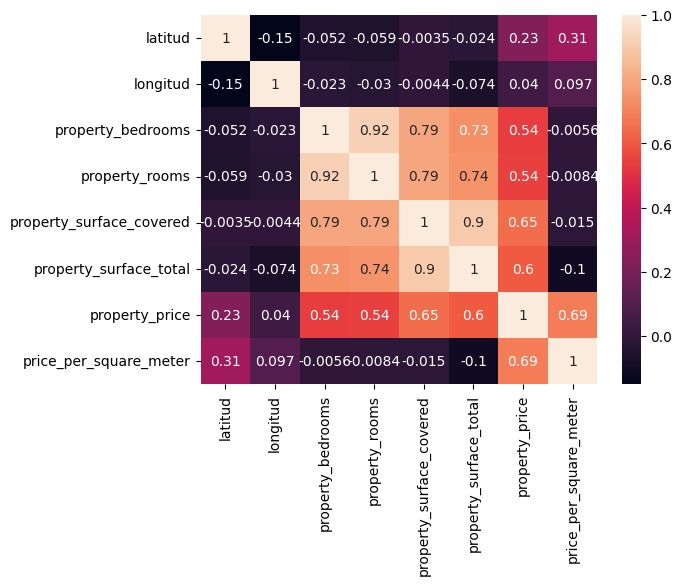

In [81]:
correlacion_matrix = conjunto_entrenamiento_sin_faltantes_final.select_dtypes(include=['float64', 'int64']).corr()
grafico_correlacion=sns.heatmap(correlacion_matrix,annot=True)

No existe una correlacion real con ninguna otra variable, aparte de la latitud y del precio (lo que es logico). Sin embargo, vamos a ver si existe una correlacion con place_l3, es decir, el barrio.

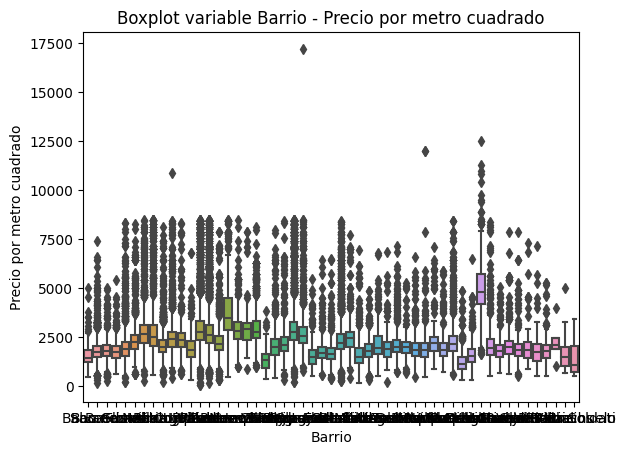

In [82]:
box_plot_place_l3_price_square_meter=sns.boxplot(x="place_l3",y="price_per_square_meter", data=conjunto_entrenamiento_sin_faltantes_final).set(title="Boxplot variable Barrio - Precio por metro cuadrado",xlabel="Barrio",ylabel="Precio por metro cuadrado")

El precio si depende del barrio, pero de momento no podemos sacar conclusiones, aunque la variable sera util para nuestras predicciones.

### Valores atipicos

In [83]:
Q1_price_per_square_meter_total = np.quantile(conjunto_entrenamiento_sin_faltantes_final['price_per_square_meter'],0.25)
Q3_price_per_square_meter_total = np.quantile(conjunto_entrenamiento_sin_faltantes_final['price_per_square_meter'],0.75)

#Rango intercuartil
IQR_price_per_square_meter_total = Q3_price_per_square_meter_total - Q1_price_per_square_meter_total

#Limite inferior Outliers
out_sup_price_per_square_meter_total = Q3_price_per_square_meter_total + 3 * IQR_price_per_square_meter_total
out_inf_price_per_square_meter_total = Q1_price_per_square_meter_total - 3 * IQR_price_per_square_meter_total

print("Outliers severos cuando price_per_square_meter > ", out_sup_price_per_square_meter_total)
print("Outliers severos cuando price_per_square_meter < ", out_inf_price_per_square_meter_total)
print("Representan un porcentaje del: ", ((len(conjunto_entrenamiento_sin_faltantes_final[conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"] > out_sup_price_per_square_meter_total])*100)/len(conjunto_entrenamiento_sin_faltantes_final)), "%")

Outliers severos cuando price_per_square_meter >  5738.970588235294
Outliers severos cuando price_per_square_meter <  -1132.3529411764703
Representan un porcentaje del:  2.396045362023844 %


Dado que representa un valor bajo del dataset, eljimos eliminar esos outliers

In [84]:
conjunto_entrenamiento_sin_faltantes_final = conjunto_entrenamiento_sin_faltantes_final[conjunto_entrenamiento_sin_faltantes_final["price_per_square_meter"] <= out_sup_price_per_square_meter_total]
conjunto_entrenamiento_sin_faltantes_final.reset_index(drop=True, inplace=True)
print("Nuevo tamaño de nuestro data frame:", conjunto_entrenamiento_sin_faltantes_final.shape)

Nuevo tamaño de nuestro data frame: (67132, 10)


# 2. Agrupamiento

En este punto se busca analizar si es posible agrupar los datos en función de algún criterio. Para
esta tarea utilizar el algoritmo K-Means y se deberán realizar los siguientes puntos:
a. Analizar la tendencia al clustering del dataset.
b. Estimar la cantidad apropiada de grupos que se deben formar.
c. Evaluar la calidad de los grupos formados realizando un análisis de Silhouette.
d. Realizar un análisis de cada grupo intentando entender en función de qué características
fueron formados.
e. Graficar sobre un mapa de CABA los avisos coloreados según el grupo al que pertenecen.
f. Repetir el análisis anterior, utilizando sólo 3 grupos.

In [85]:
conjunto_entrenamiento_final = conjunto_entrenamiento_sin_faltantes_final.copy()

In [86]:
conjunto_entrenamiento_final

,latitud,longitud,place_l3,property_type,property_bedrooms,property_rooms,property_surface_covered,property_surface_total,property_price,price_per_square_meter
0,-34.637319,-58.361124,Boca,Departamento,2.0,3.0,55.0,58.0,82900.0,1429.310345
1,-34.628647,-58.361871,Boca,Departamento,3.0,4.0,70.0,70.0,99000.0,1414.285714
2,-34.610027,-58.401934,Balvanera,Departamento,2.0,4.0,104.0,138.0,146000.0,1057.971014
3,-34.631621,-58.416825,Boedo,PH,2.0,4.0,73.0,118.0,250000.0,2118.644068
4,-34.623886,-58.412746,Boedo,PH,1.0,2.0,46.0,61.0,100000.0,1639.344262
...,...,...,...,...,...,...,...,...,...,...
67127,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,98514.0,2736.500000
67128,-34.590332,-58.420135,Palermo,Departamento,3.0,4.0,72.0,81.0,200000.0,2469.135802
67129,-34.576232,-58.441949,Palermo,Departamento,2.0,3.0,57.0,62.0,130000.0,2096.774194
67130,-34.582800,-58.442800,Palermo,Departamento,1.0,1.0,32.0,36.0,100273.0,2785.361111


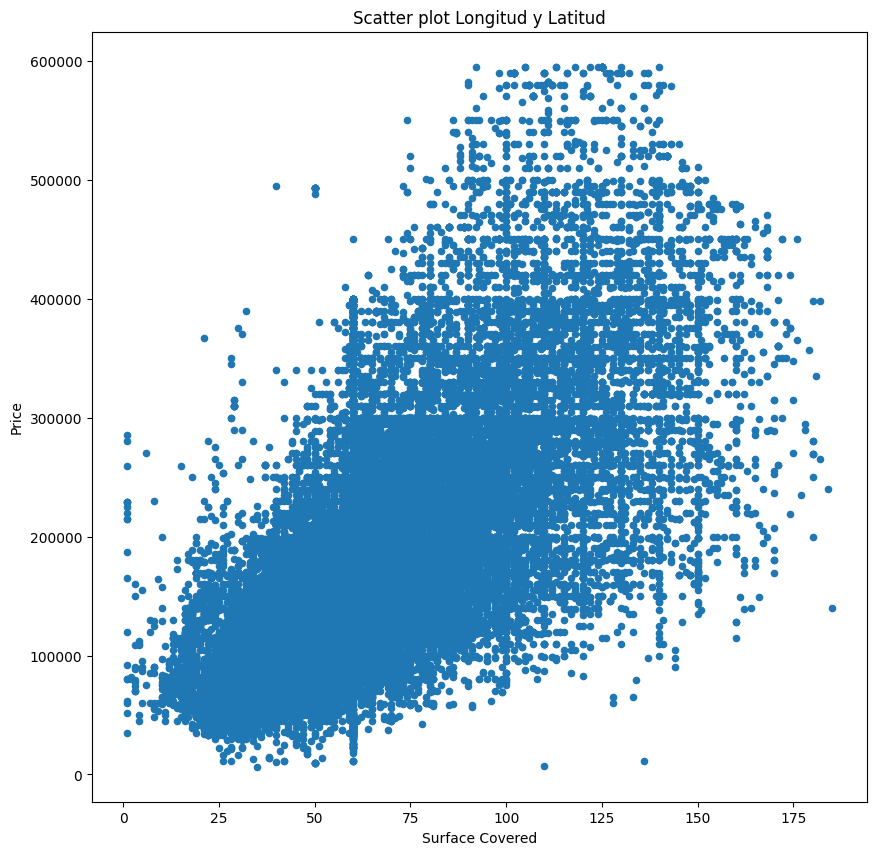

In [87]:
scatter_plot_longitud_latitud=conjunto_entrenamiento_final.plot.scatter(title="Scatter plot Longitud y Latitud",
                x='property_surface_covered', y='property_price',
                xlabel='Surface Covered', ylabel='Price',
                figsize=(10,10))

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

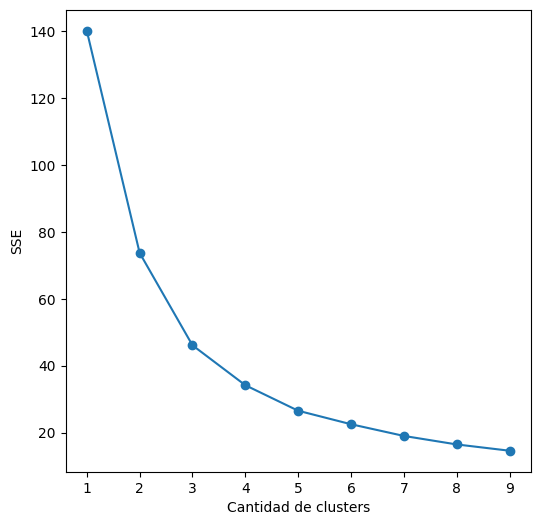

In [88]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(conjunto_entrenamiento_final[["longitud", "latitud"]])
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

In [89]:
from sklearn.metrics import silhouette_score

list_k = list(range(2, 10))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(conjunto_entrenamiento_final[["longitud", "latitud"]])

    score = silhouette_score (conjunto_entrenamiento_final[["longitud", "latitud"]], preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 